In [5]:
# leemos los arhivos de train, val y test
import pandas as pd
df_train = pd.read_csv('train_timeseries.csv')
df_val = pd.read_csv('validation_timeseries.csv')
df_test = pd.read_csv('test_timeseries.csv')

In [2]:
# comparo validacion y test con sweetviz compare
import sweetviz as sv
report = sv.compare([df_val, "Validation"], [df_test, "Test"])
# guardo el reporte
report.show_html('compare.html', open_browser=False, layout='widescreen', scale=0.8)

                                             |          | [  0%]   00:00 -> (? left)

Report compare.html was generated.



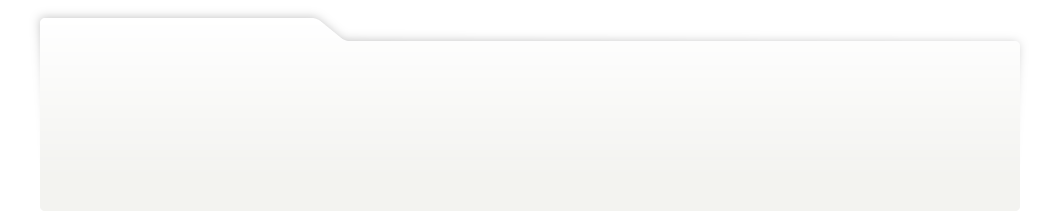
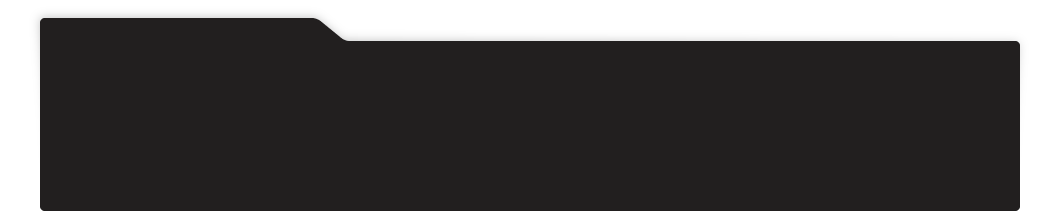
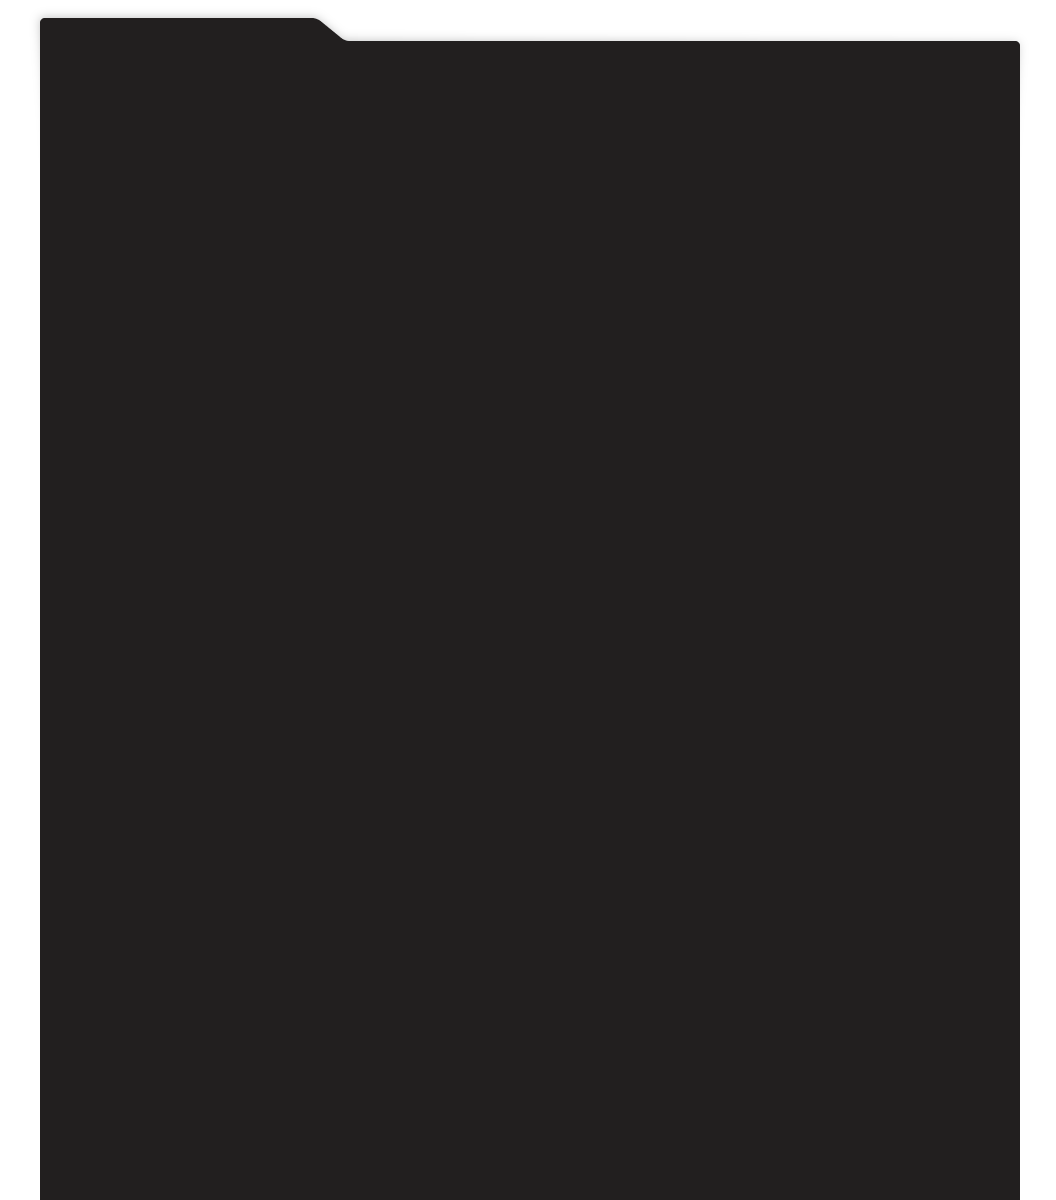
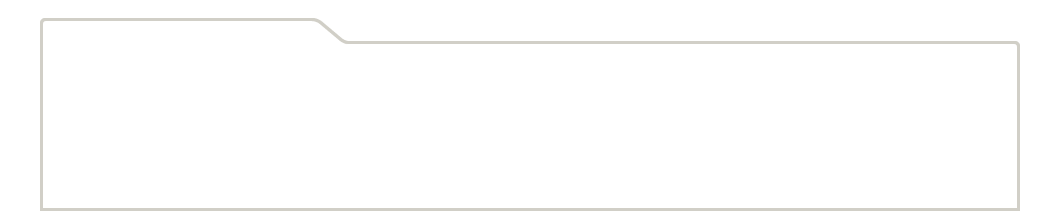
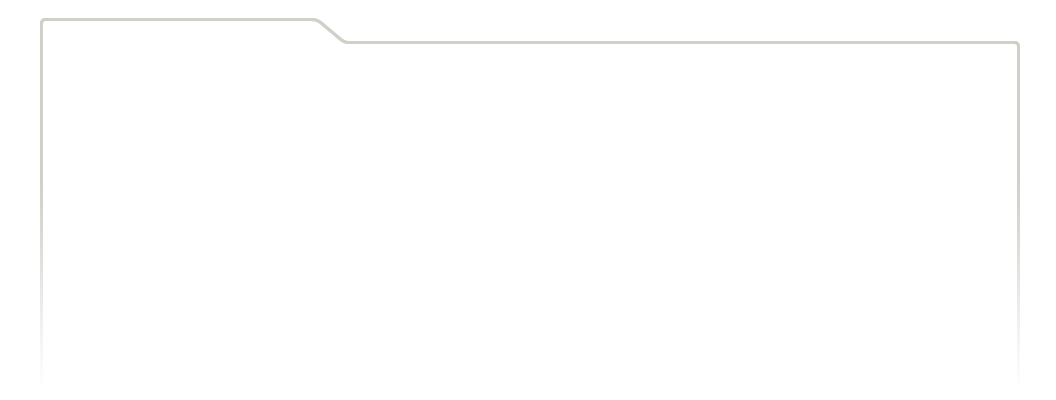
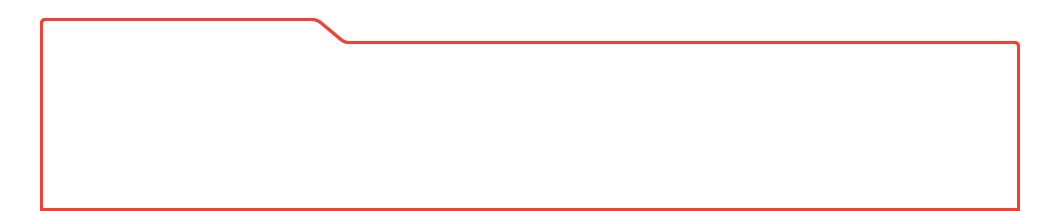
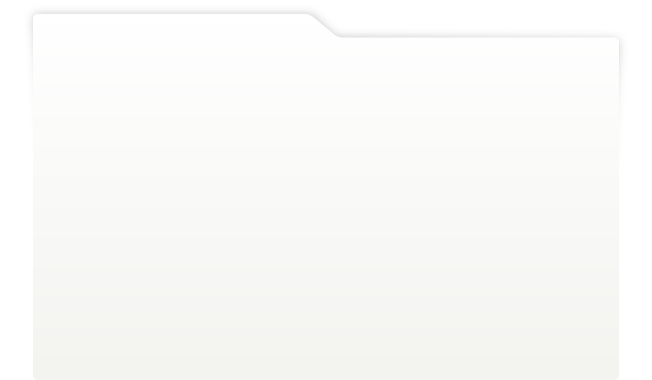
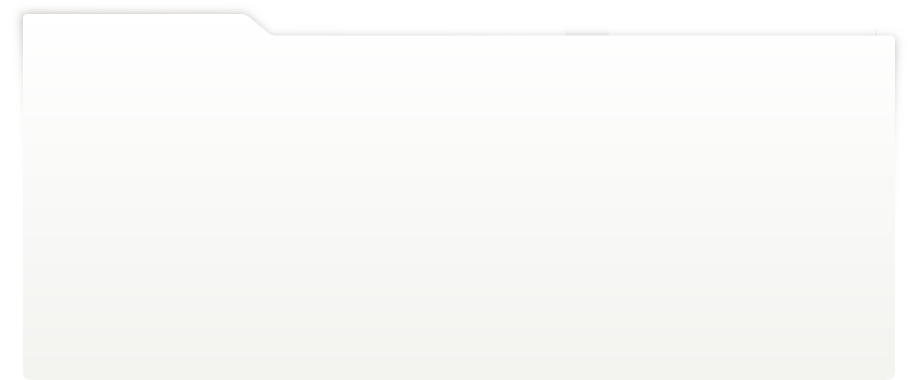
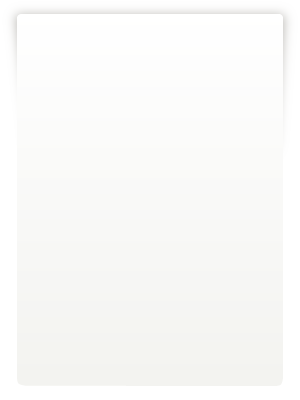
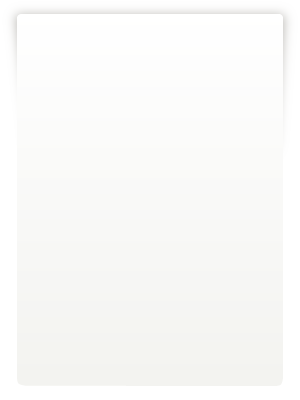
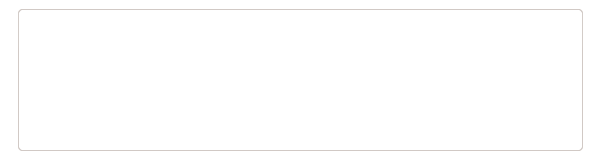
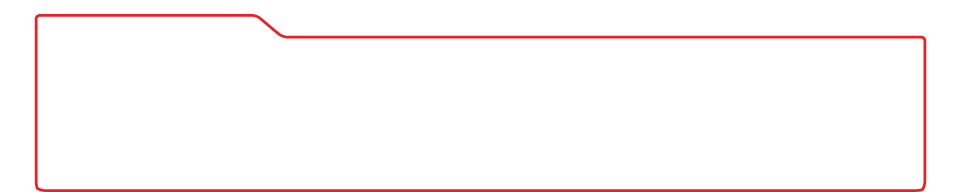
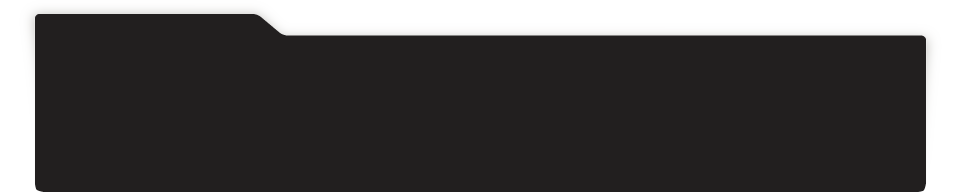
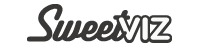
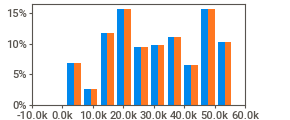
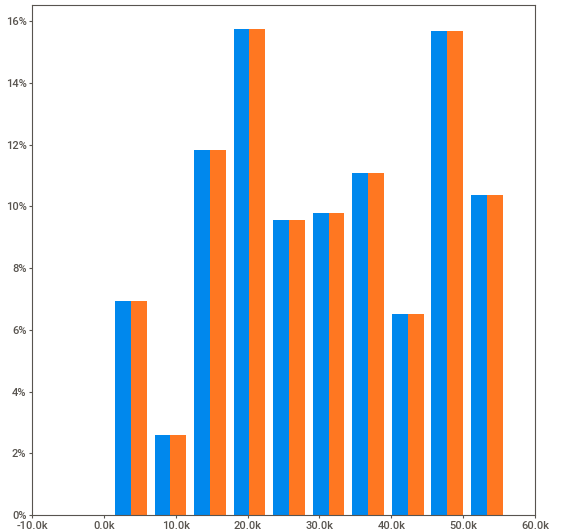
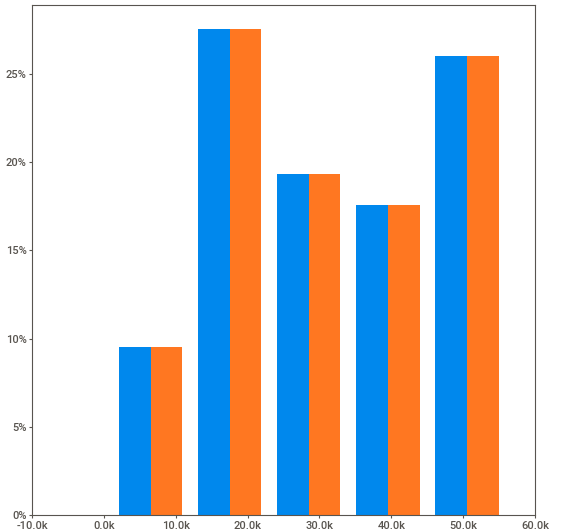
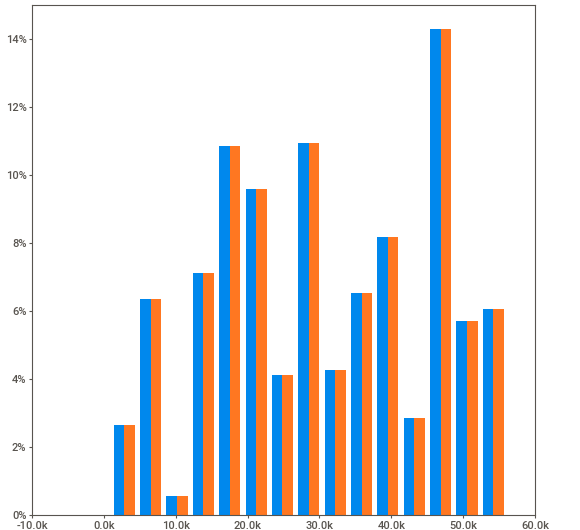
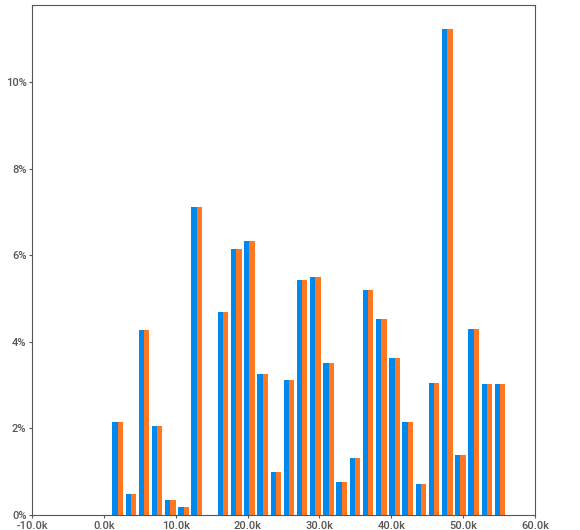
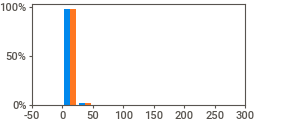
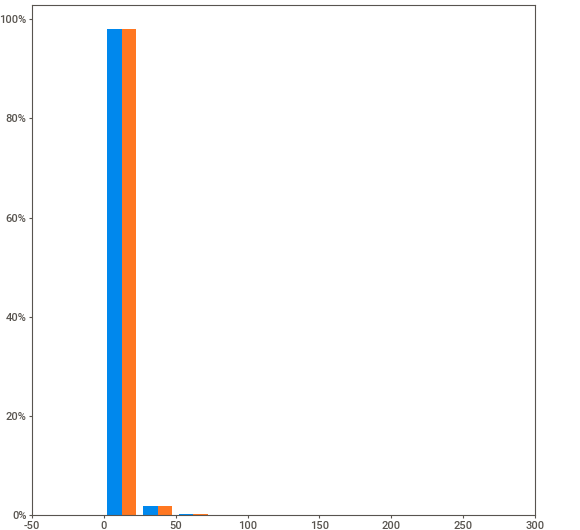
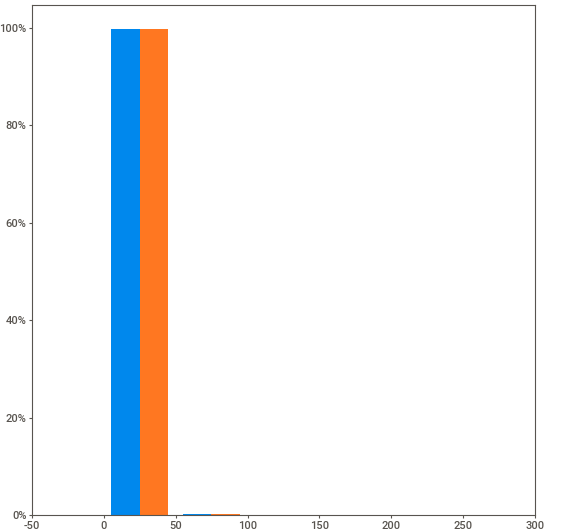
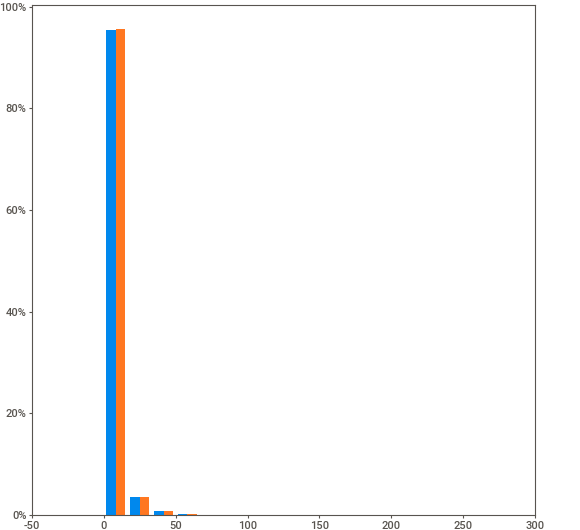
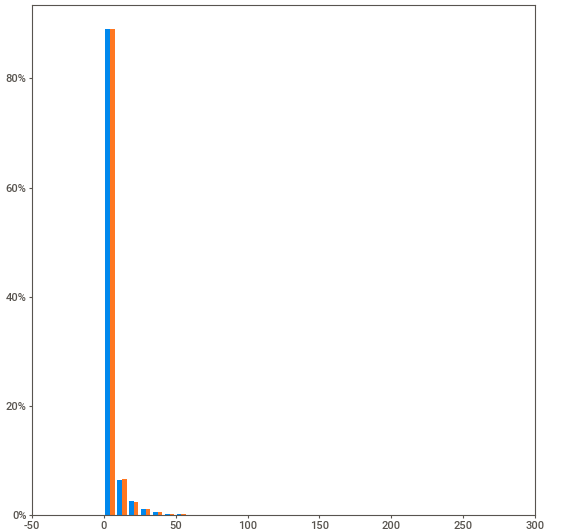
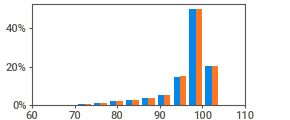
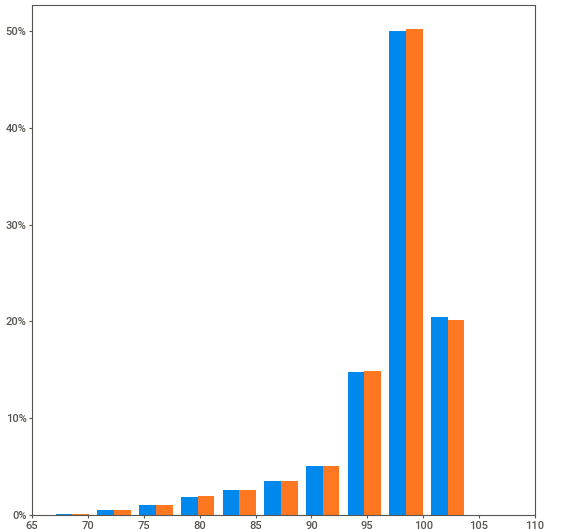
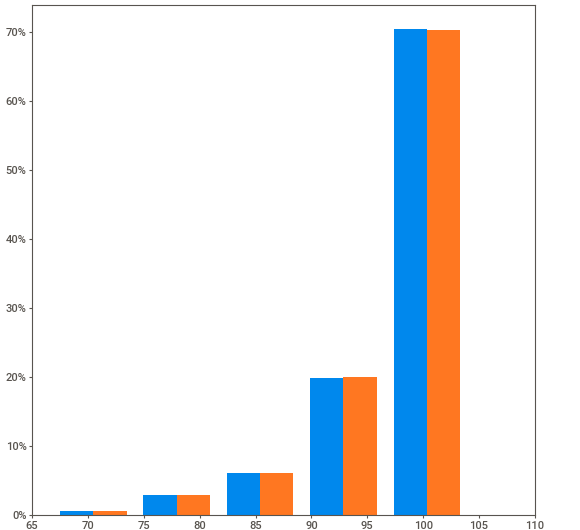
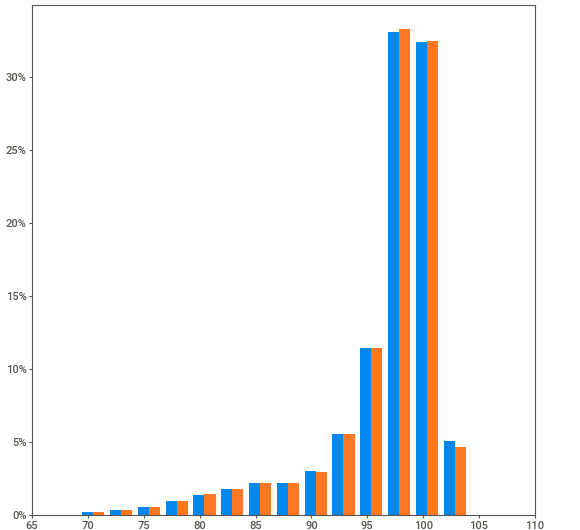
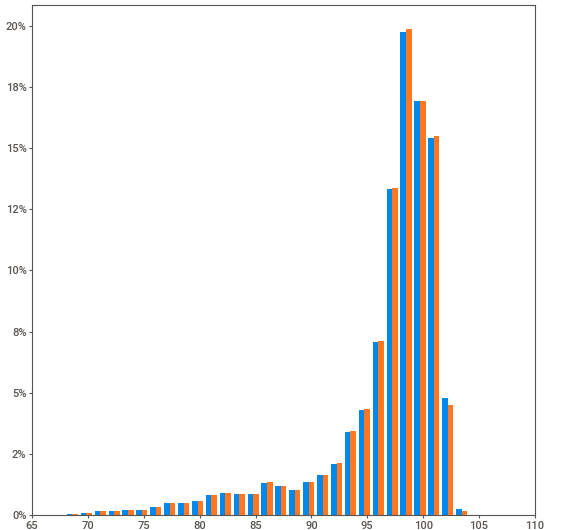
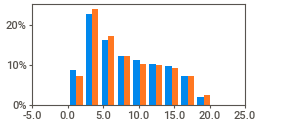
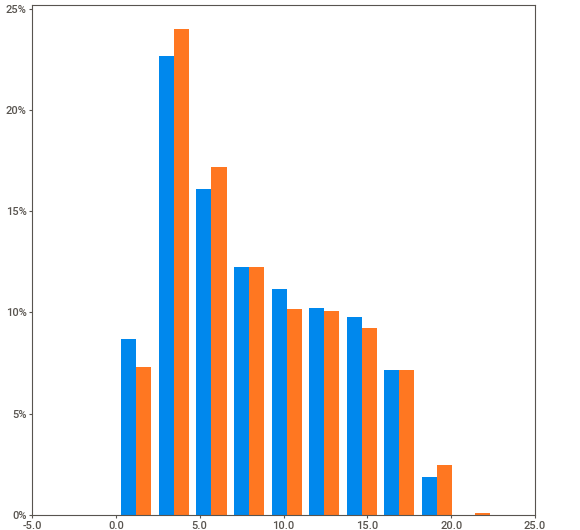
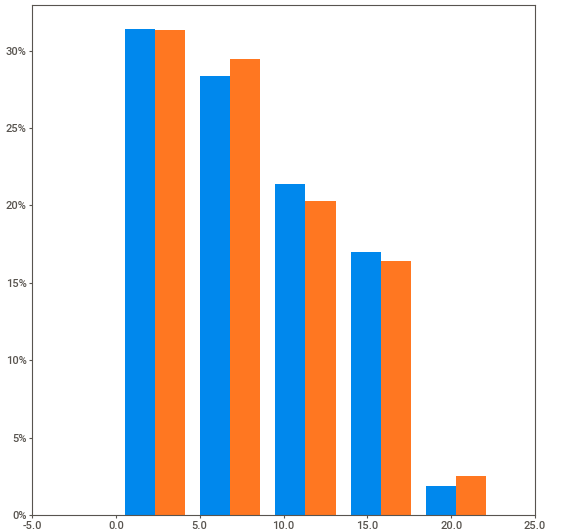
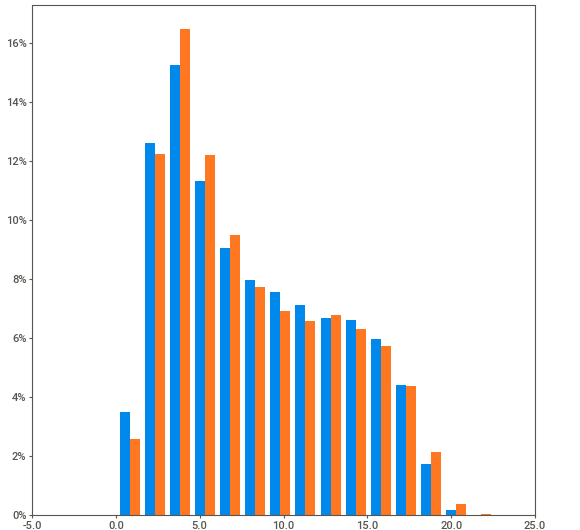
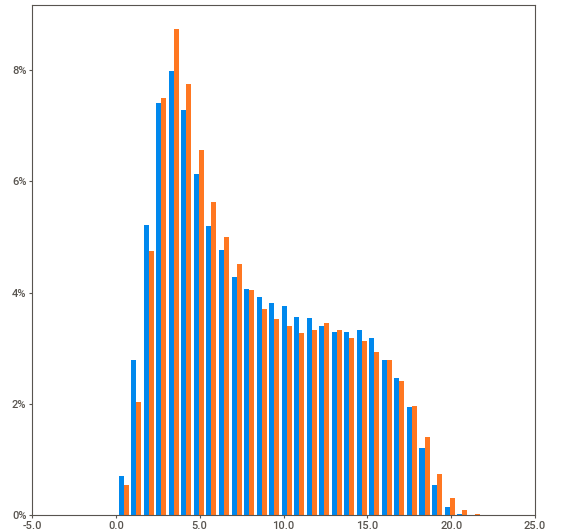
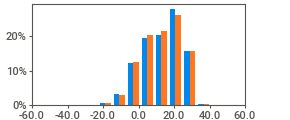
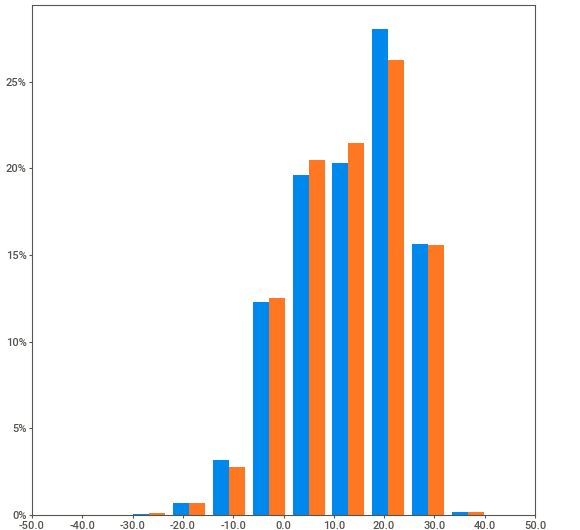
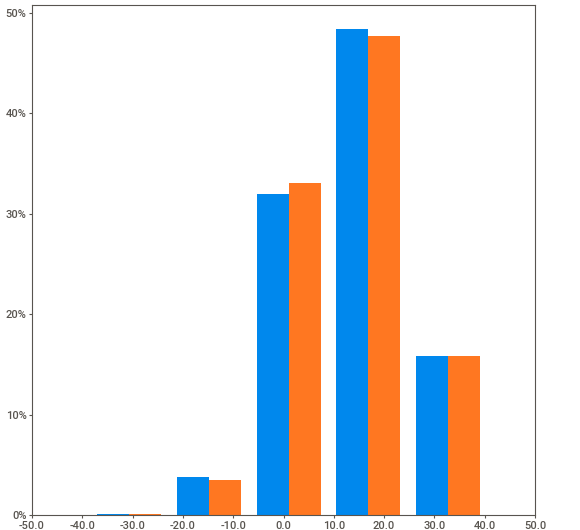
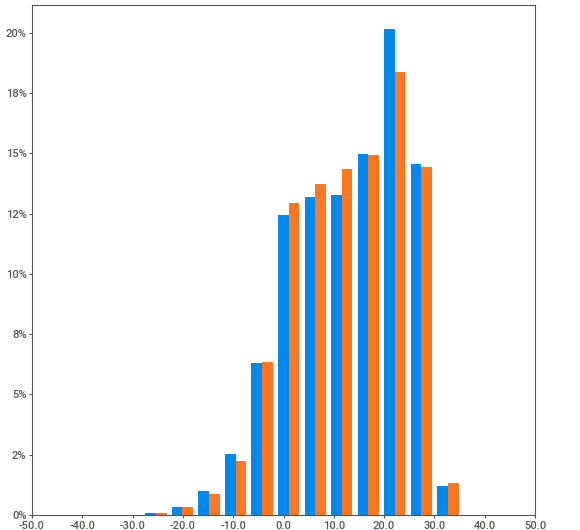
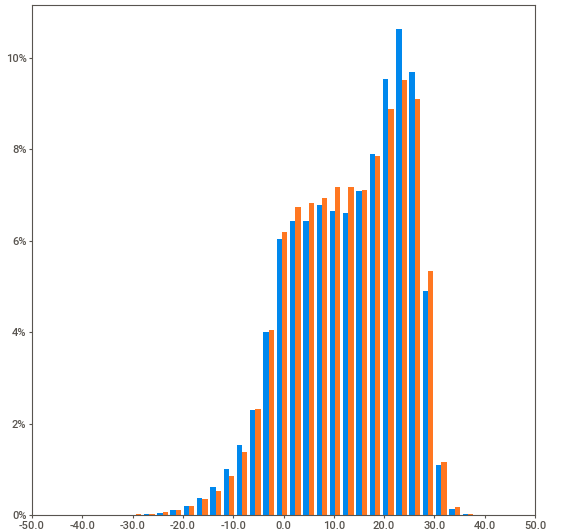
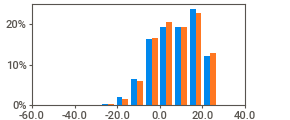
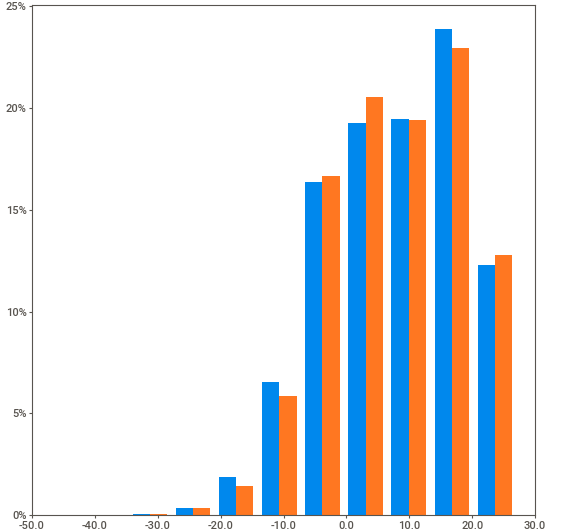
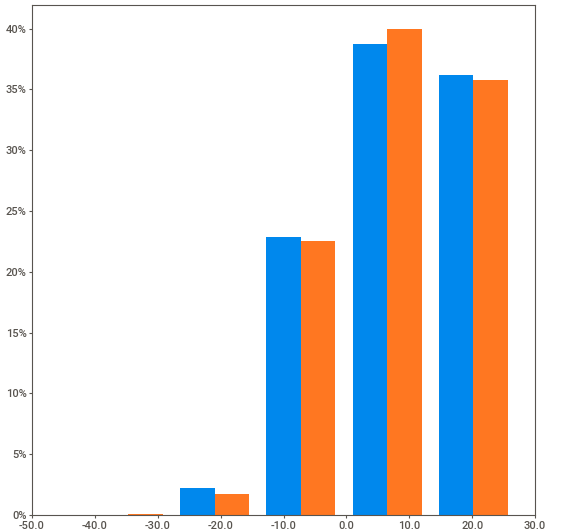
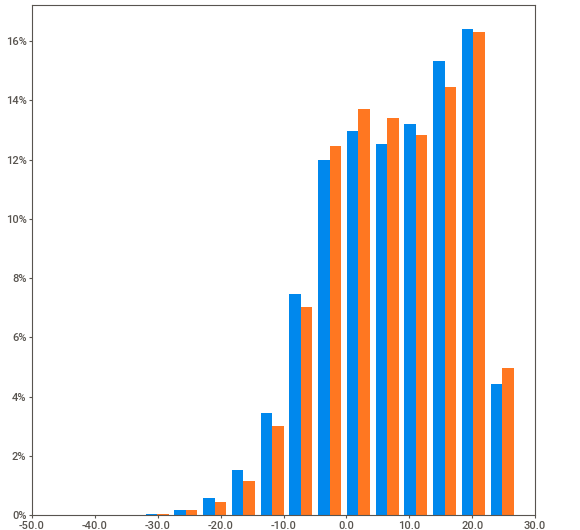
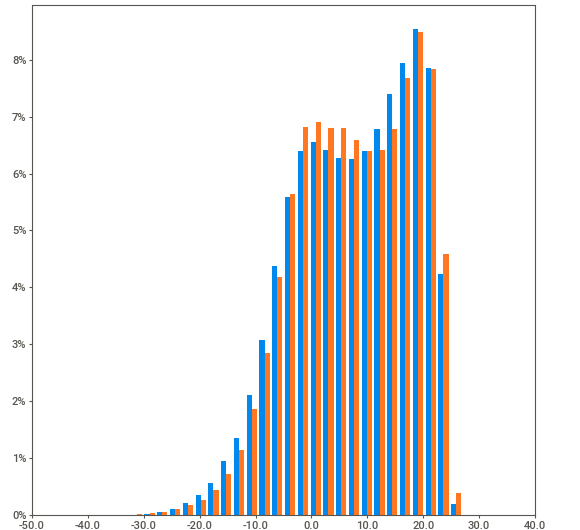
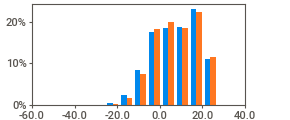
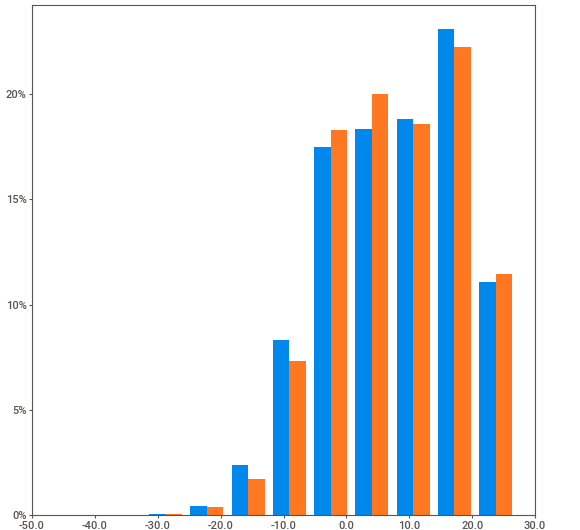
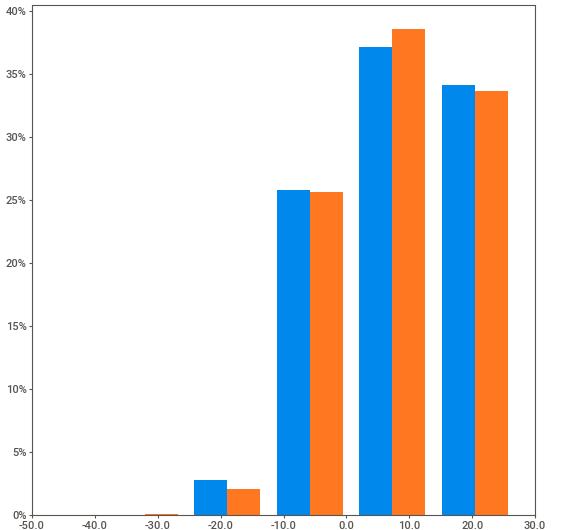
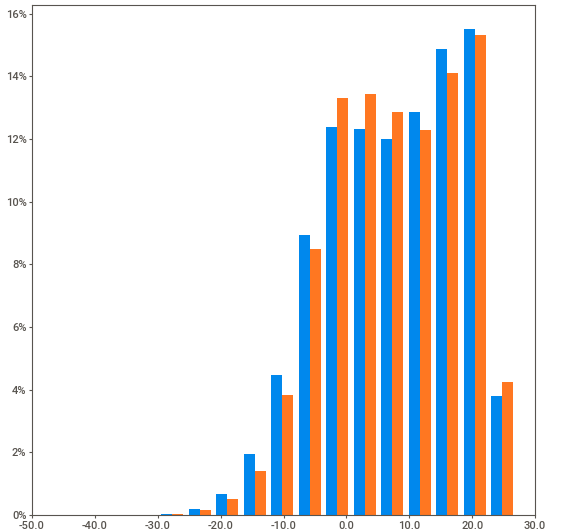
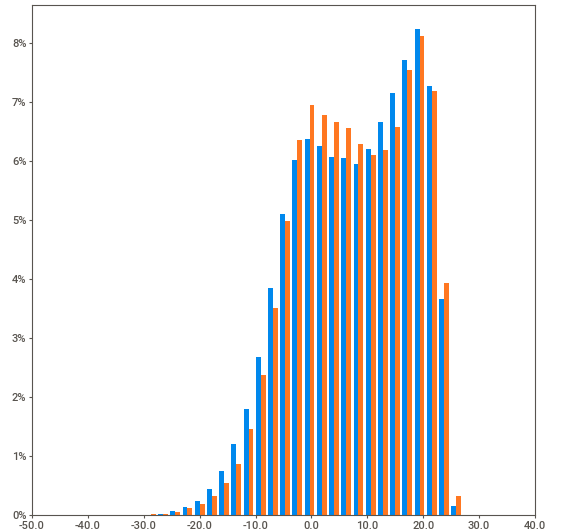
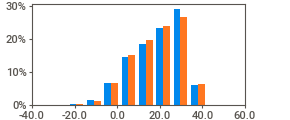
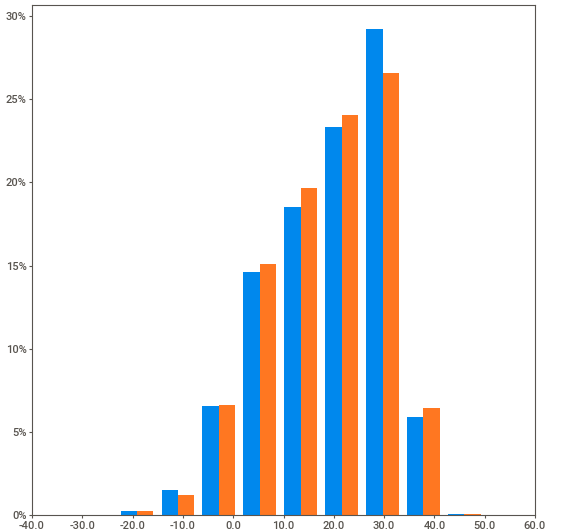
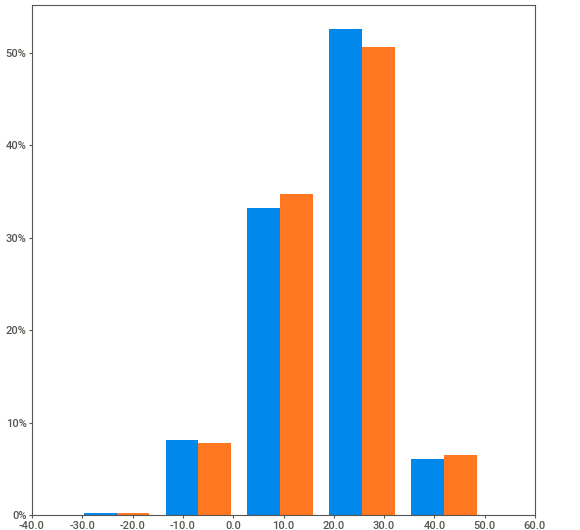
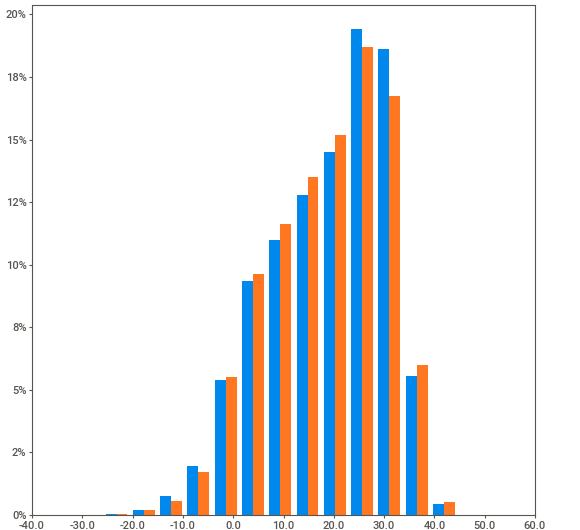
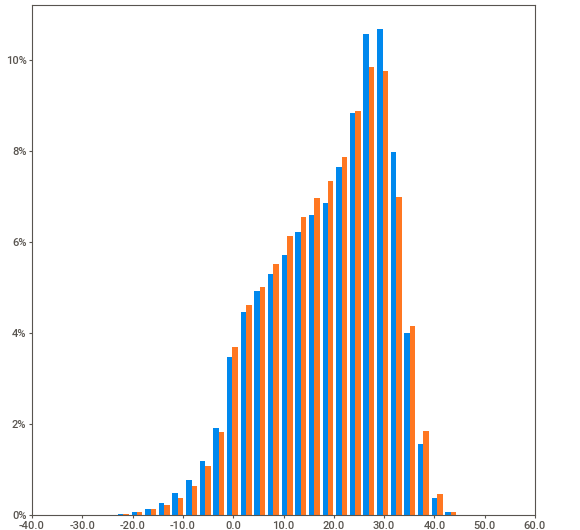
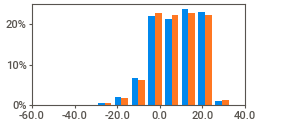
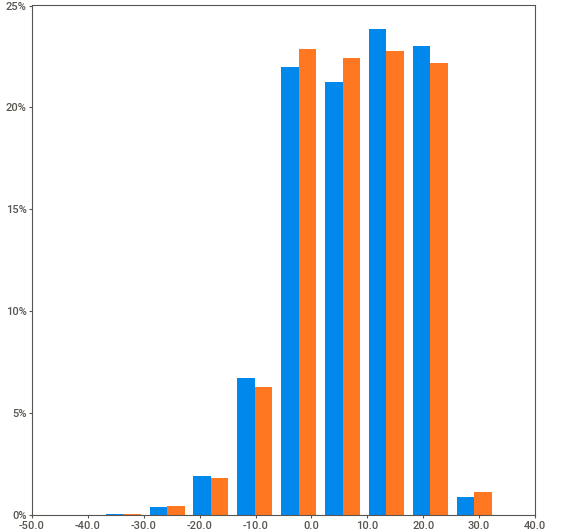
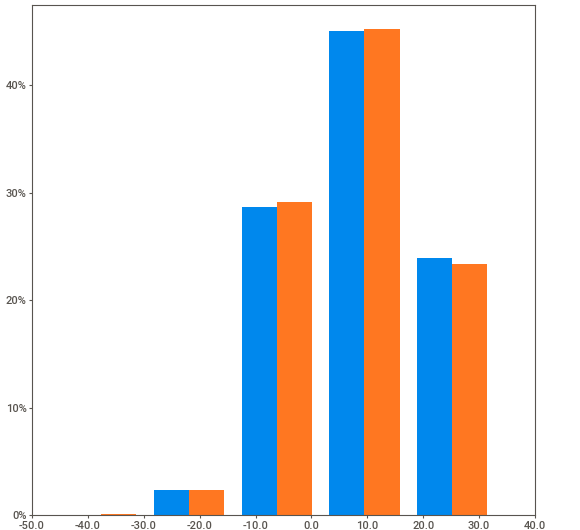
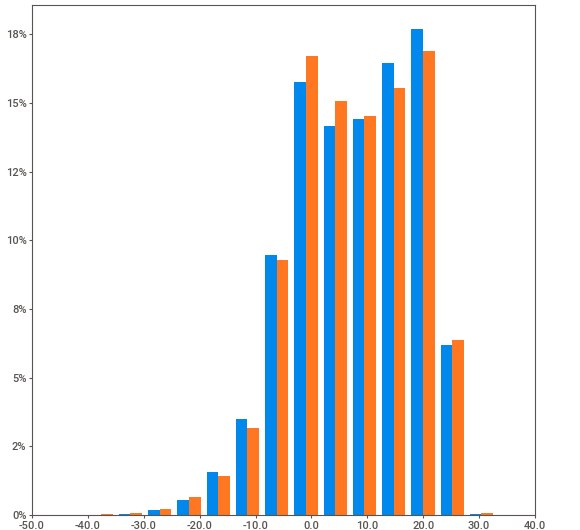
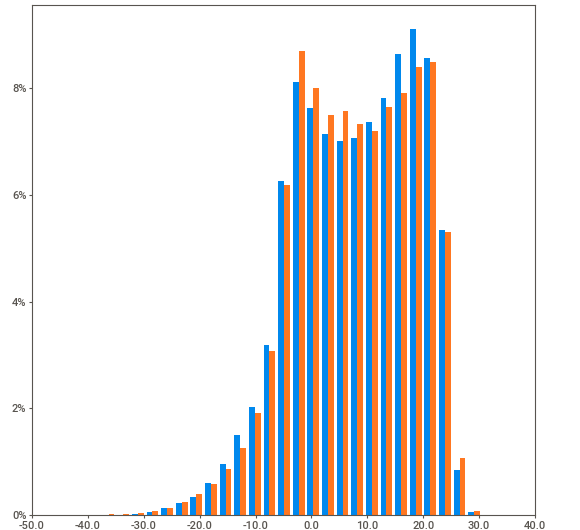
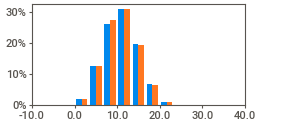
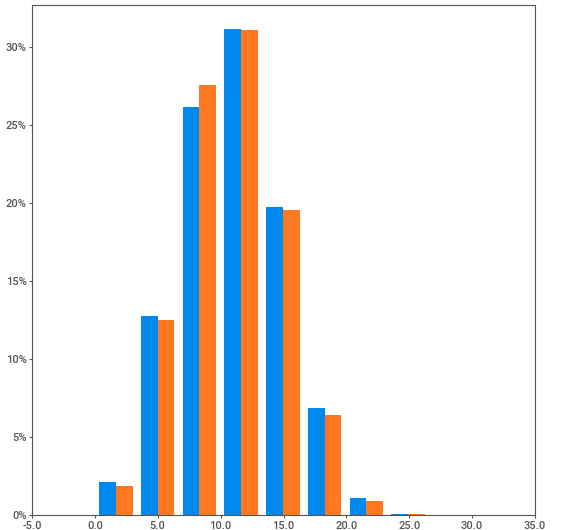
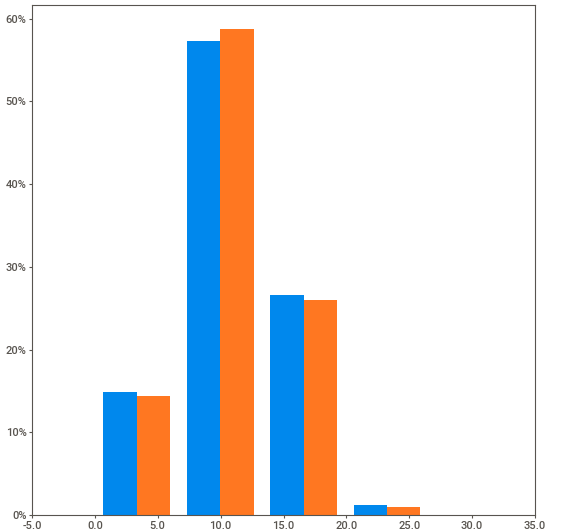
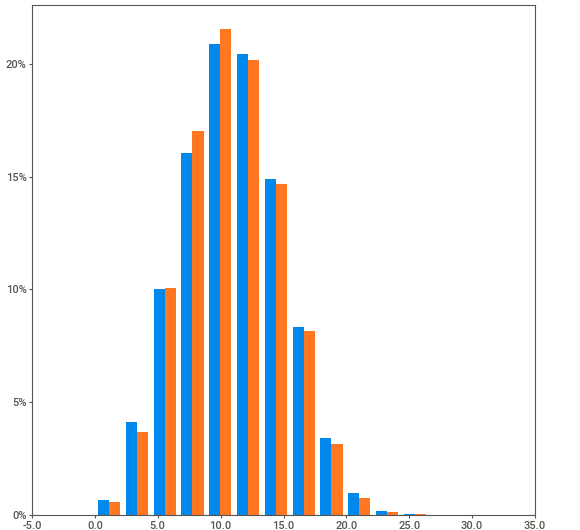
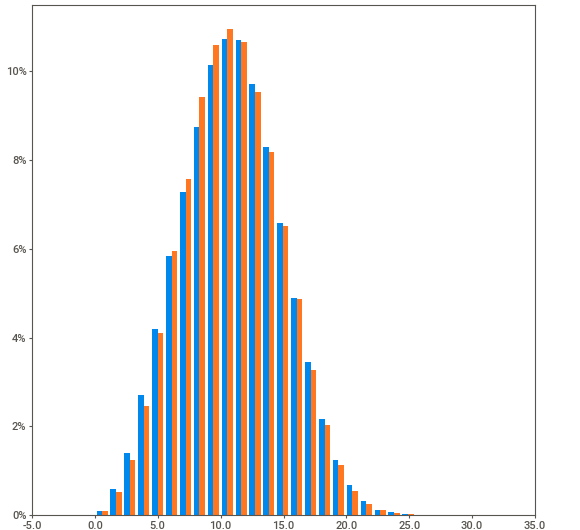
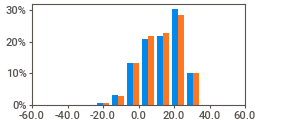
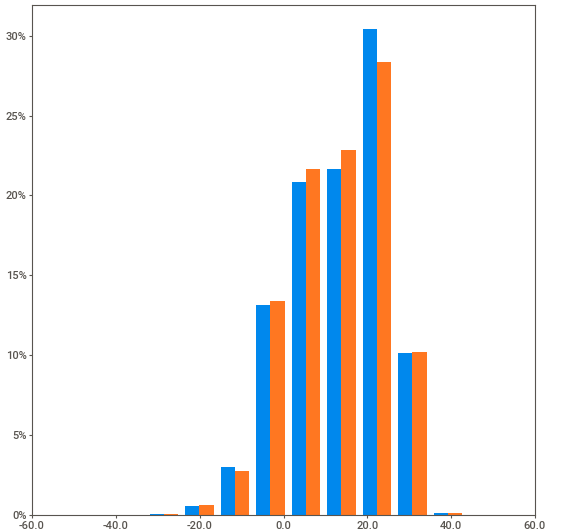
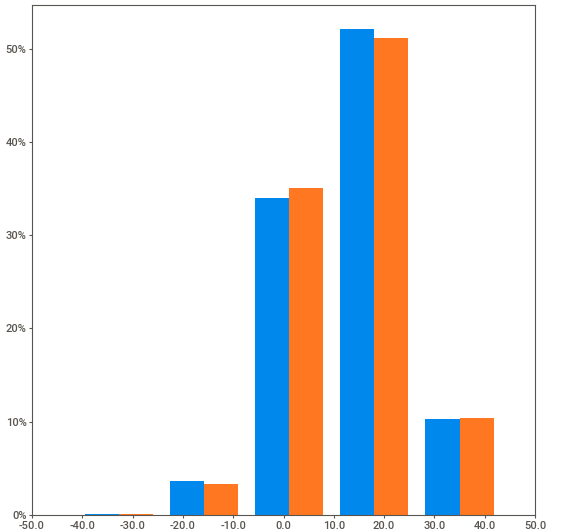
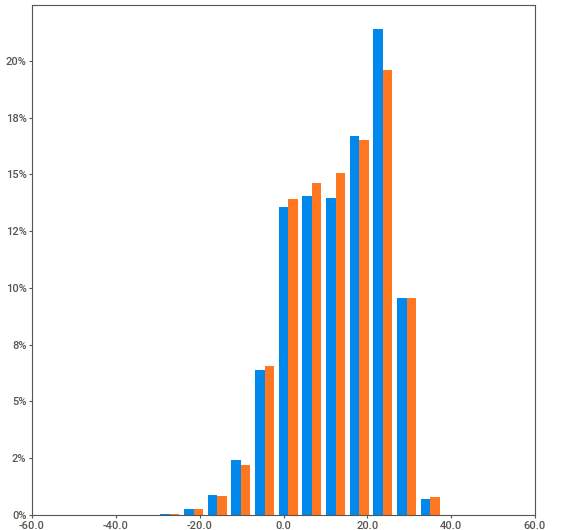
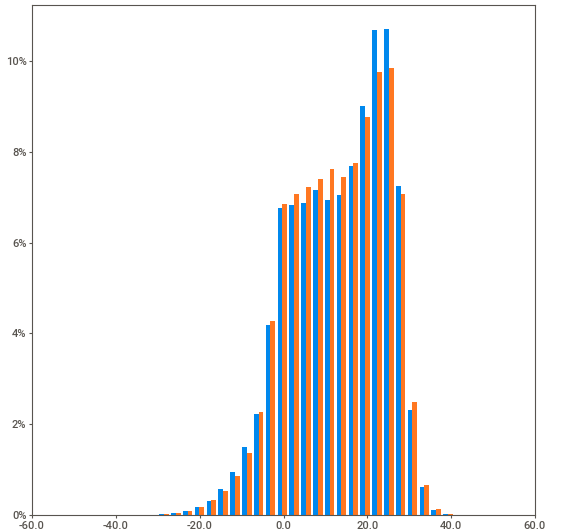
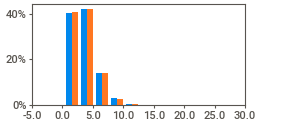
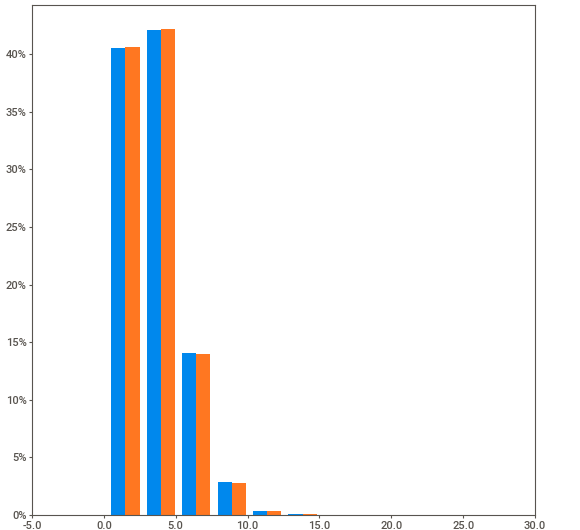
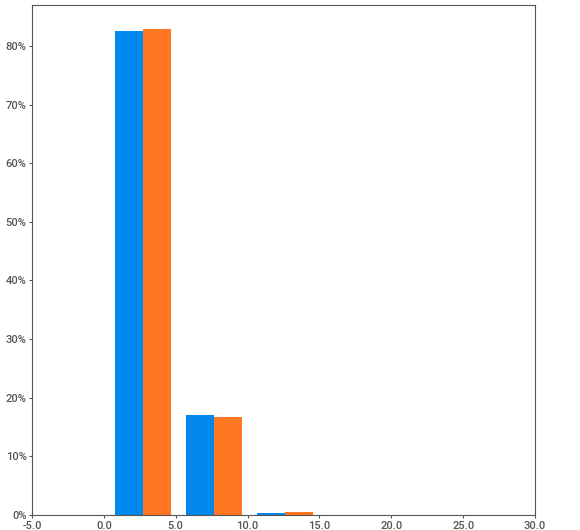
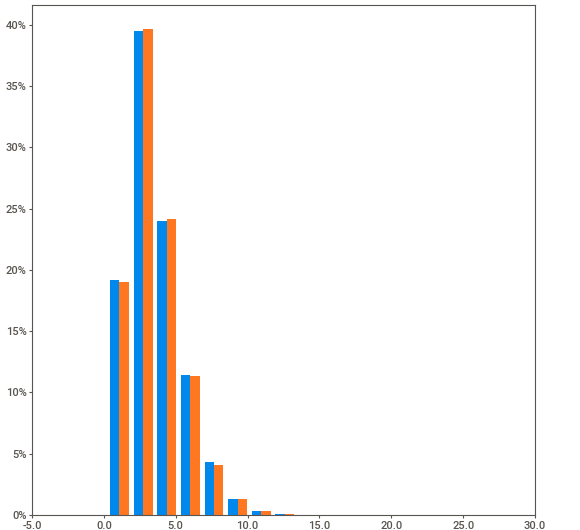
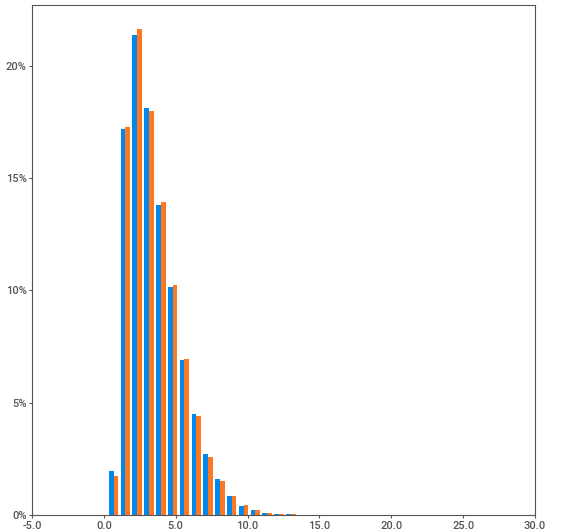
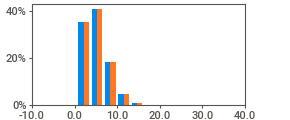
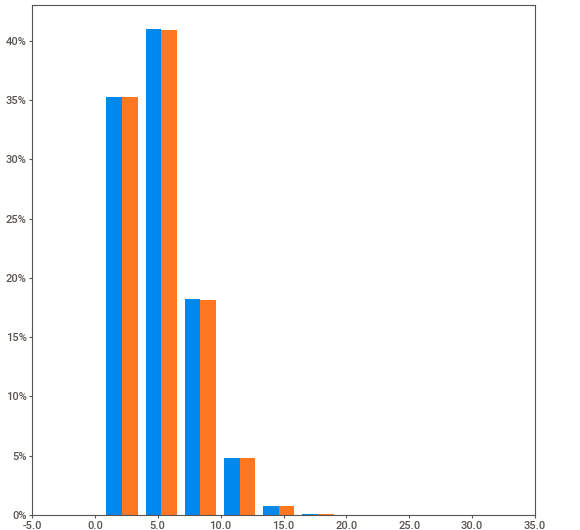
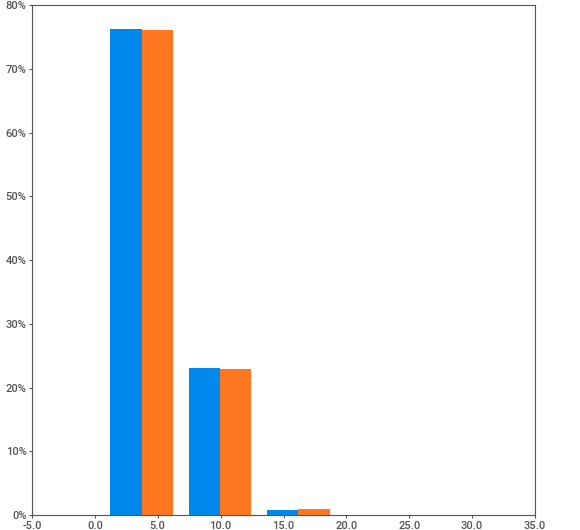
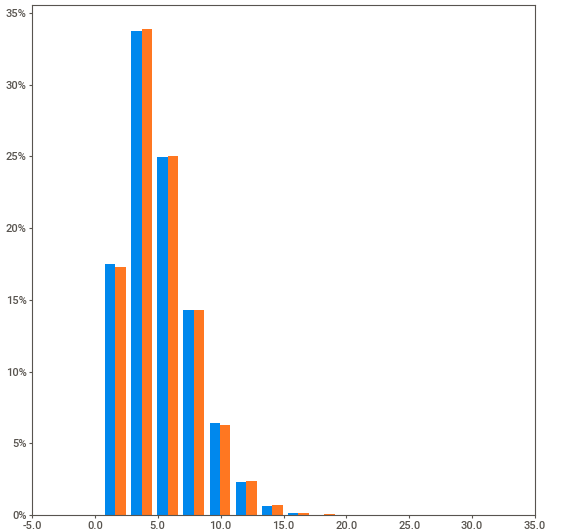
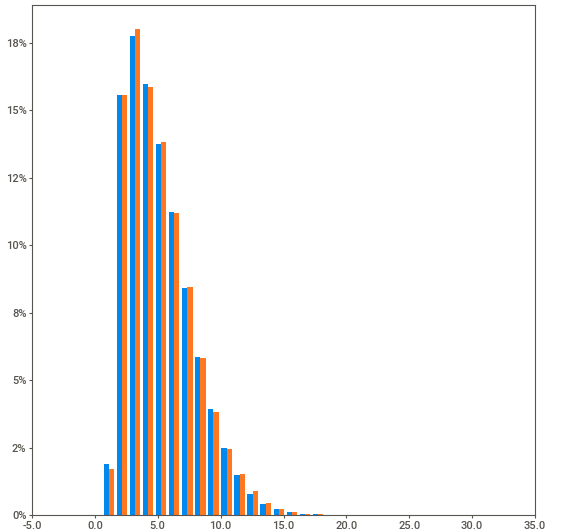
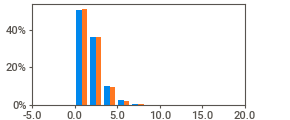
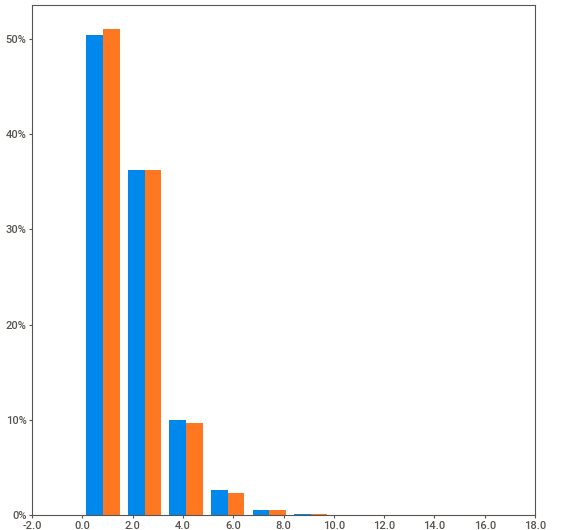
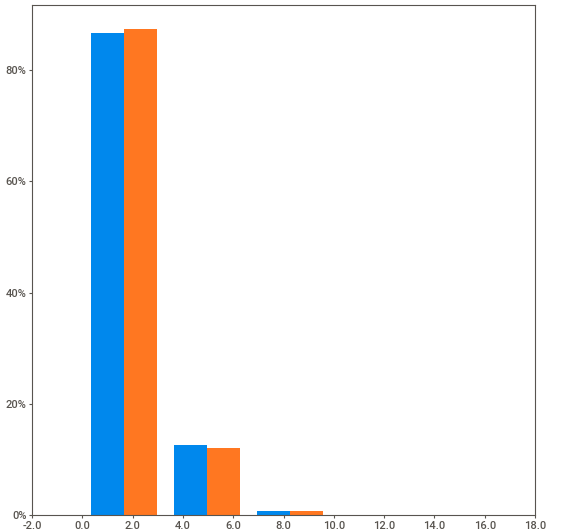
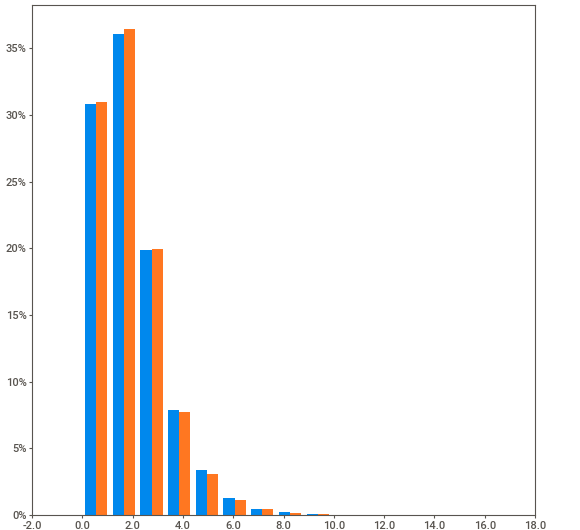
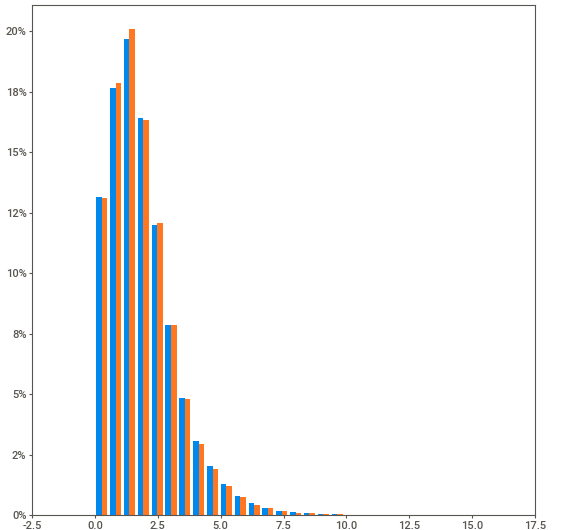
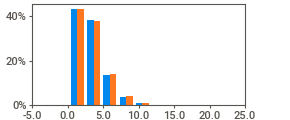
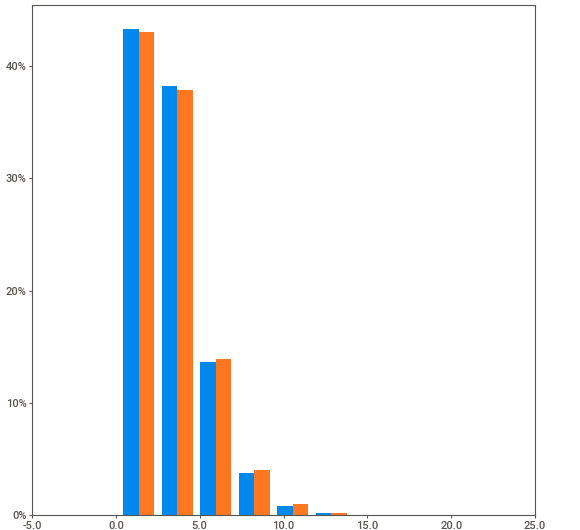
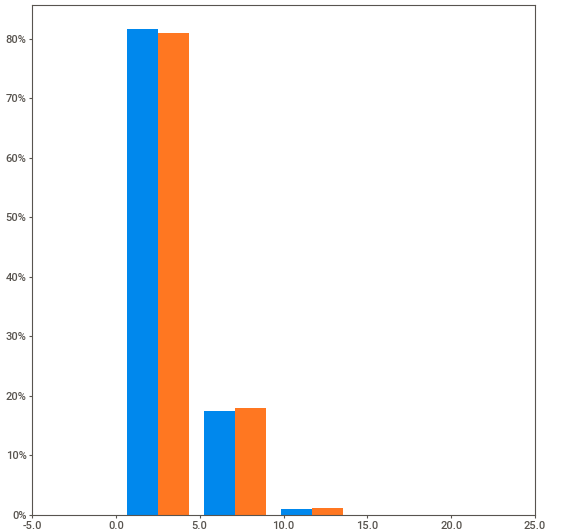
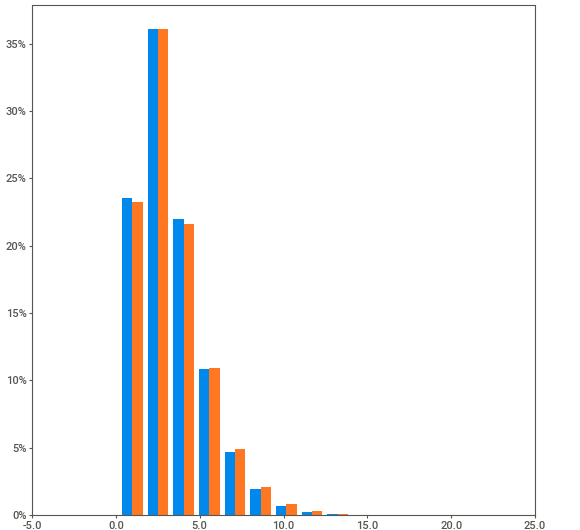
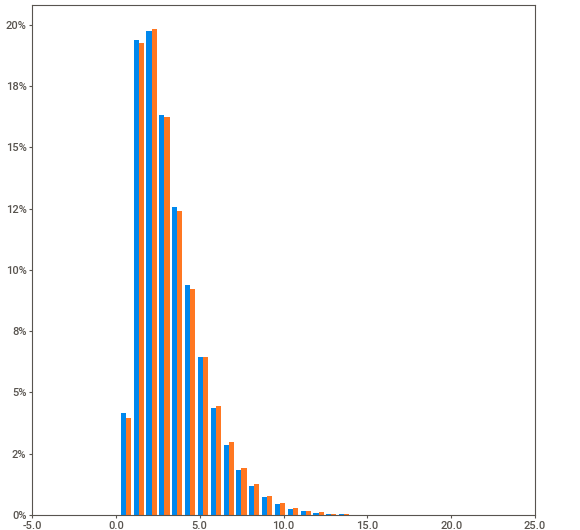
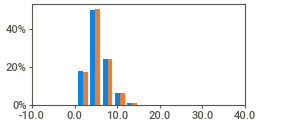
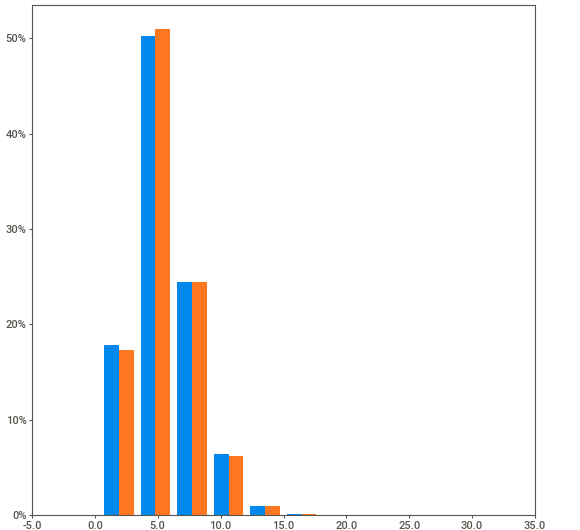
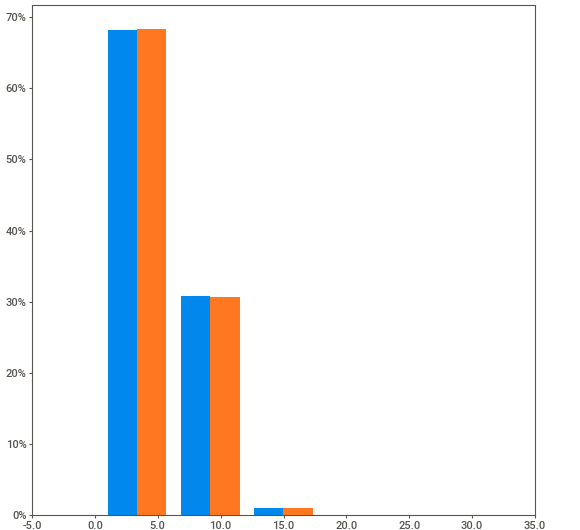
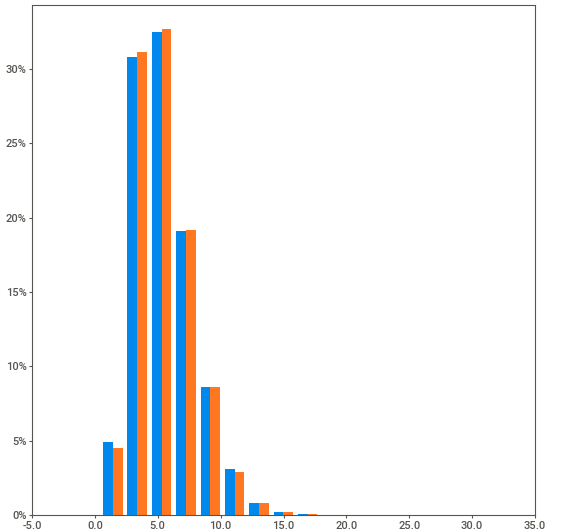
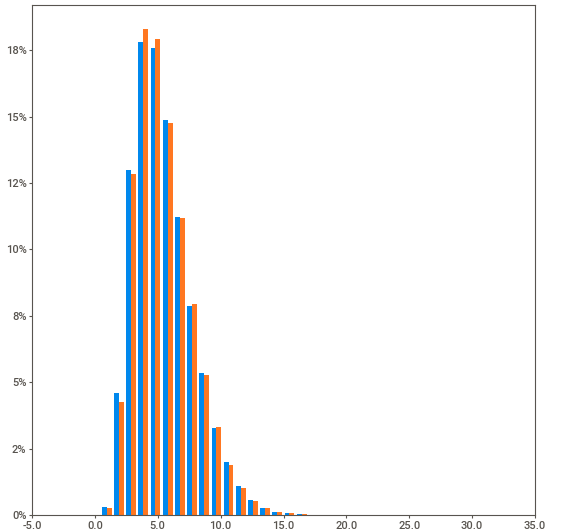
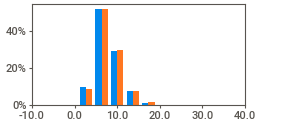
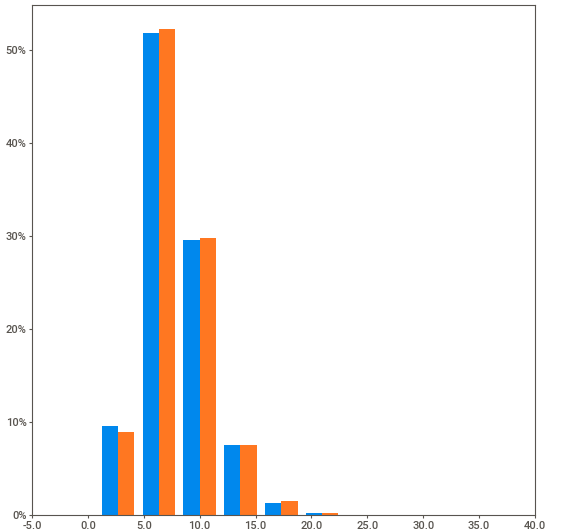
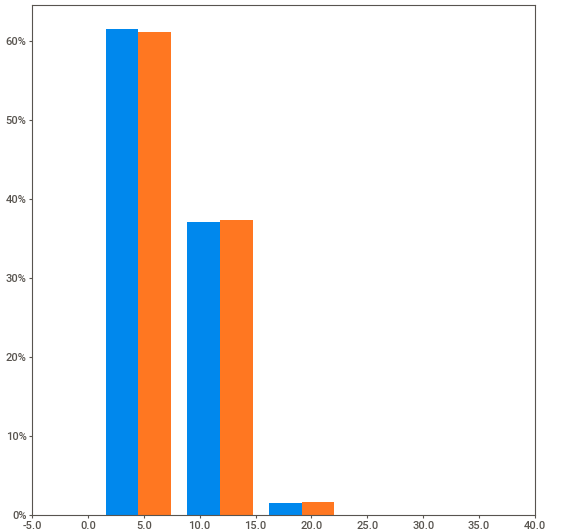
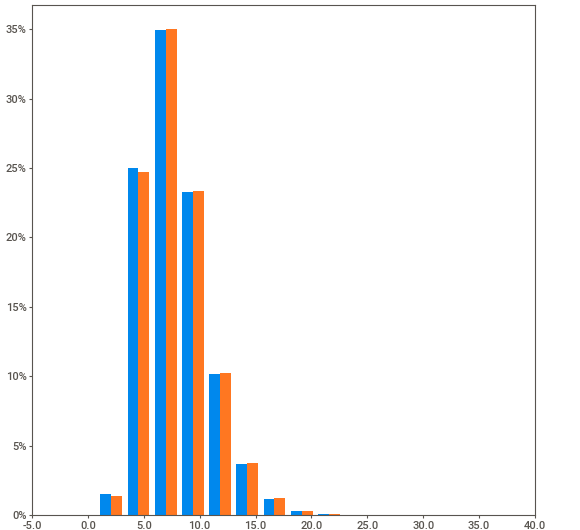
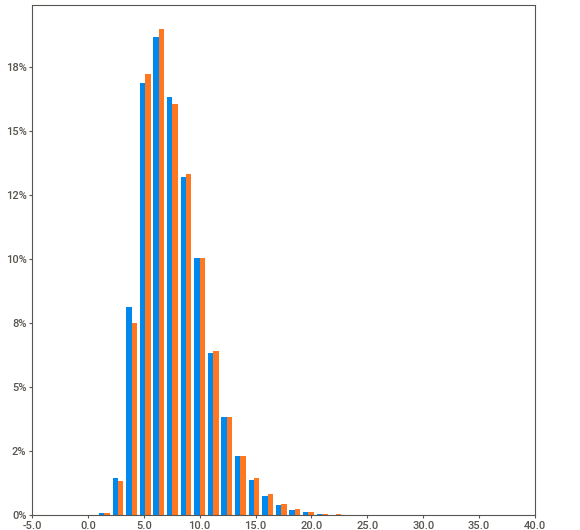
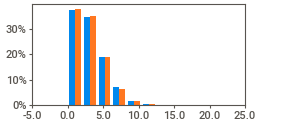
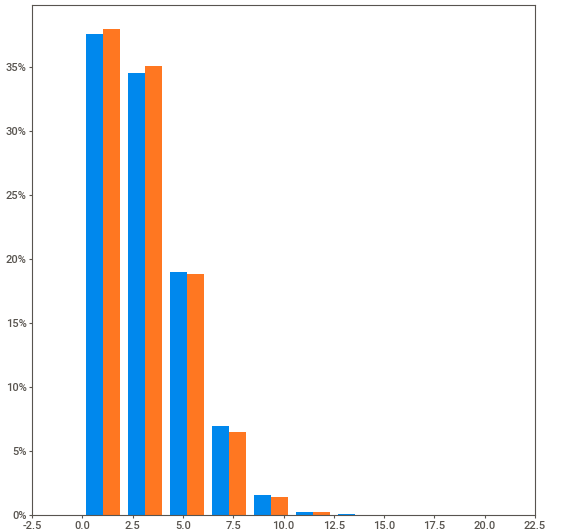
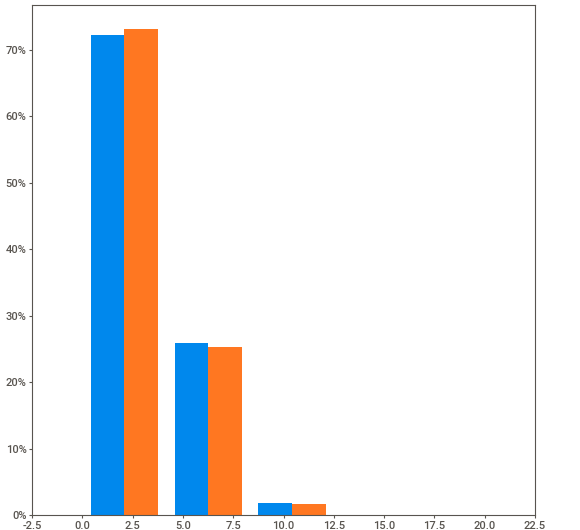
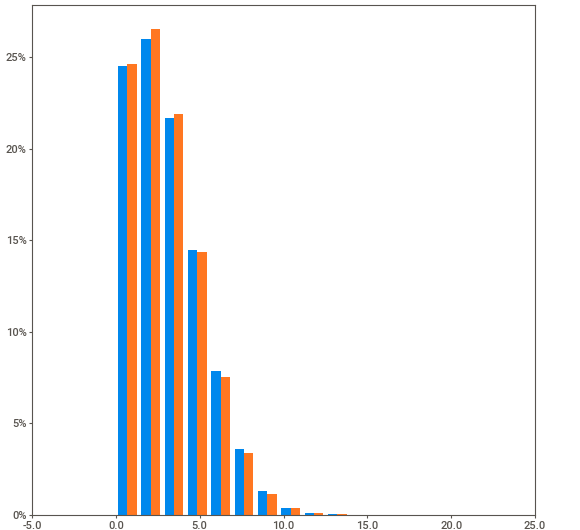
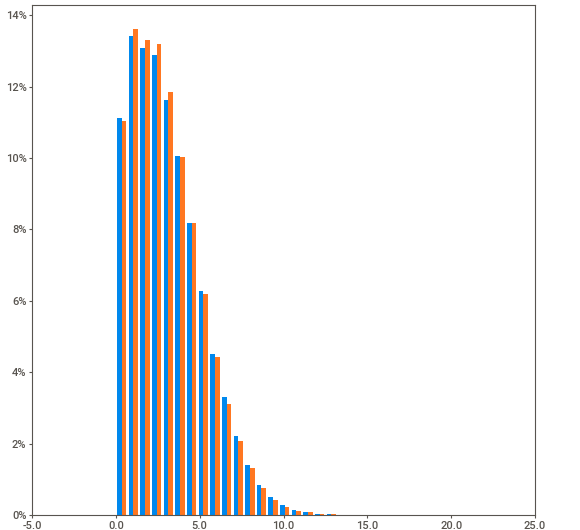
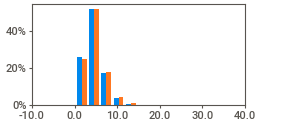
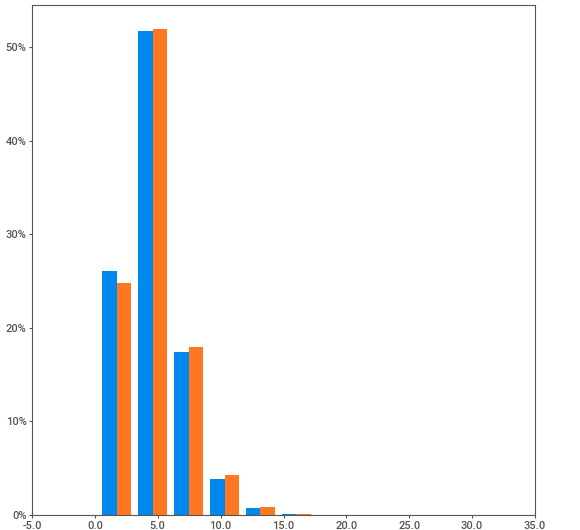
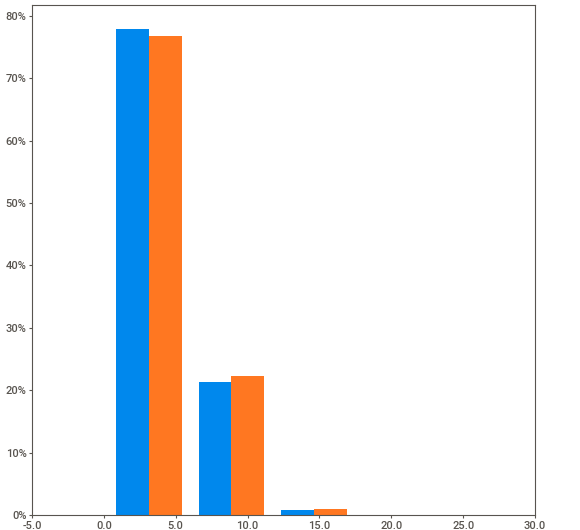
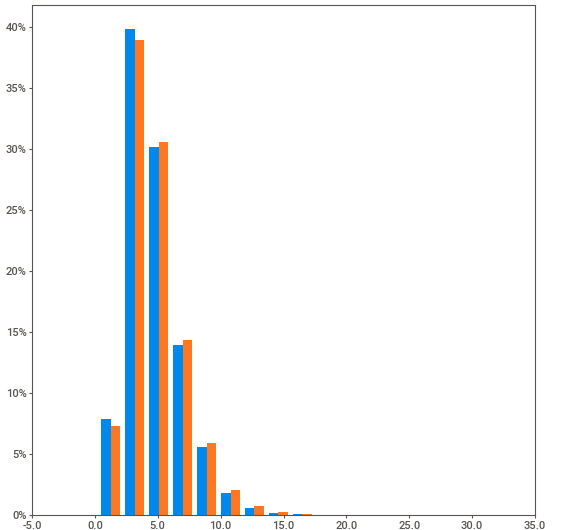
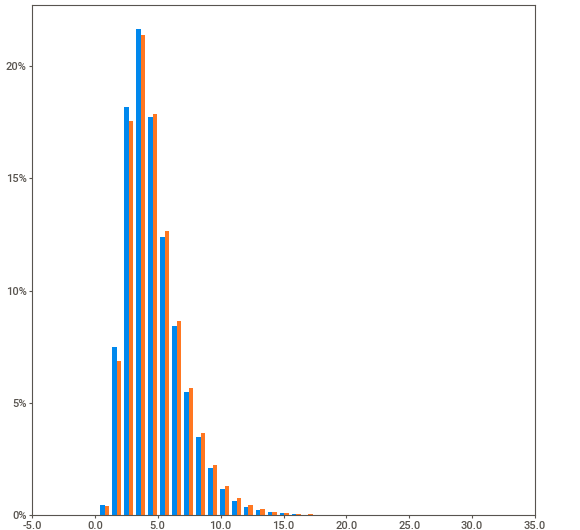
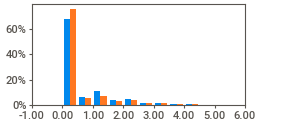
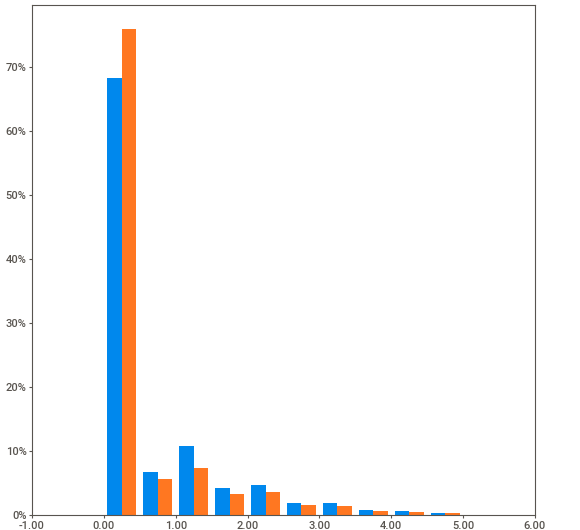
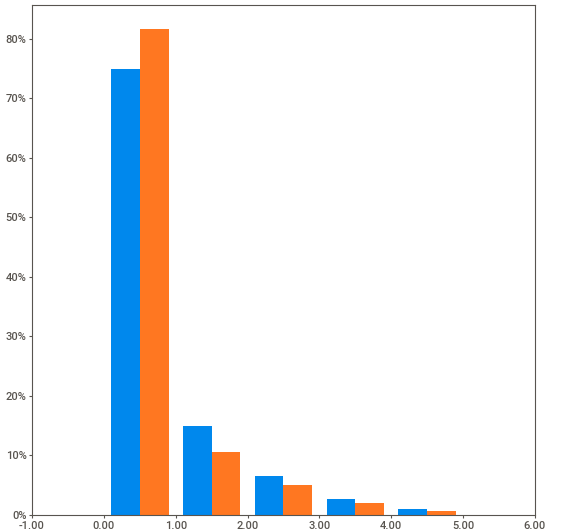
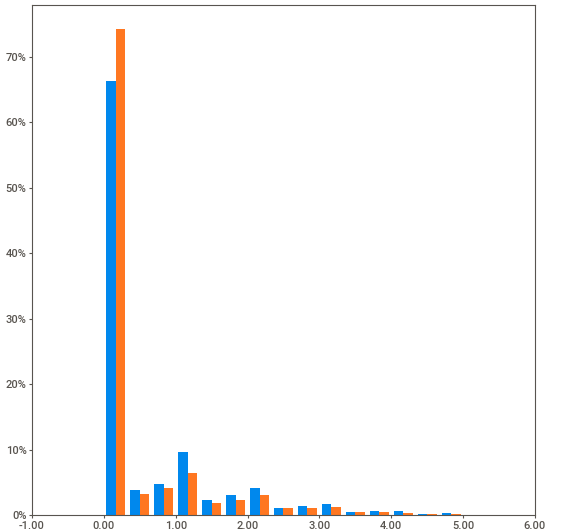
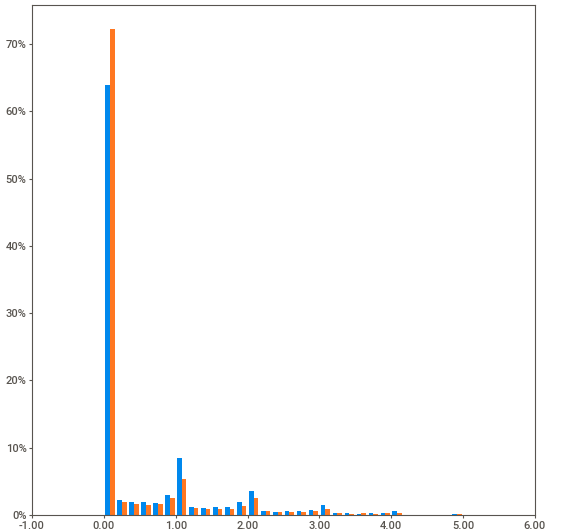
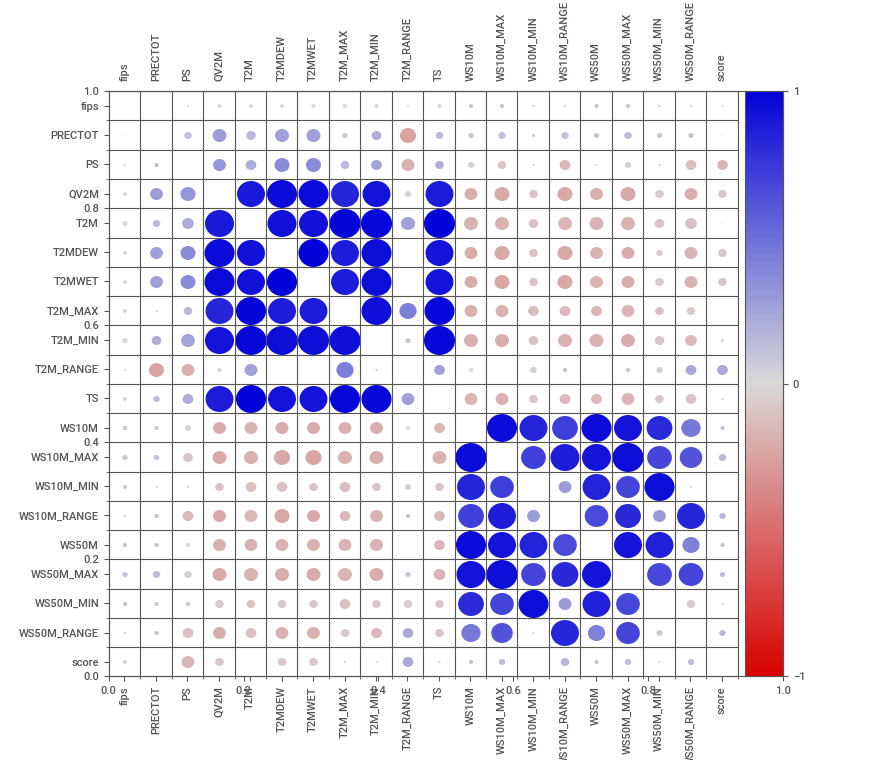
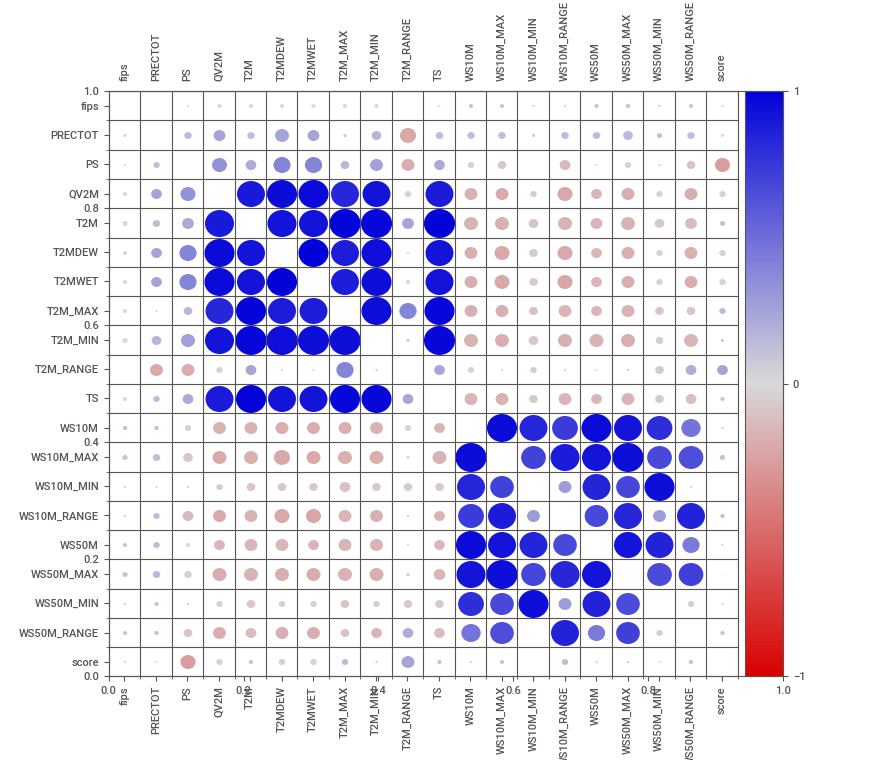

In [4]:
report.show_notebook()

In [6]:
# Ordenamos df_train por el campo fecha (date) de forma descendente
df_train = df_train.sort_values('date', ascending=False)

# Creo un df_train_copy con los ultimos 4 años de datos
df_train_copy = df_train[df_train['date'] >= '2014-01-01']

                                             |          | [  0%]   00:00 -> (? left)


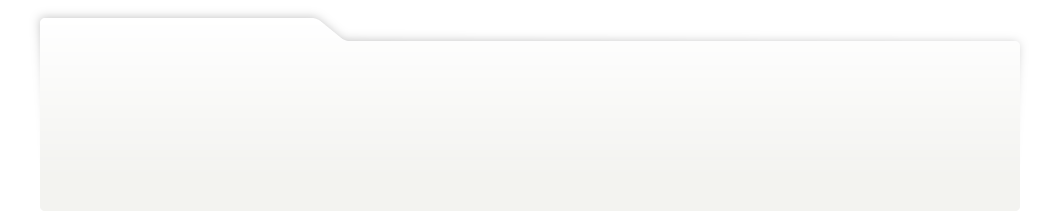
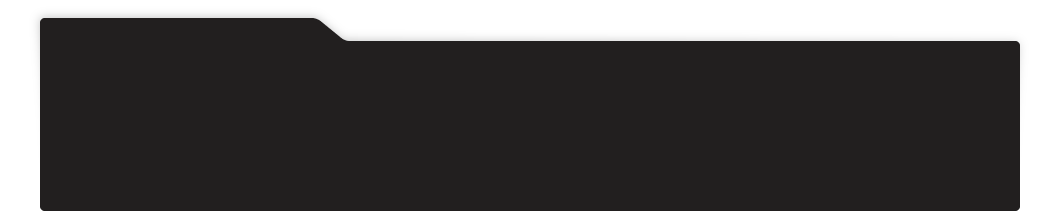
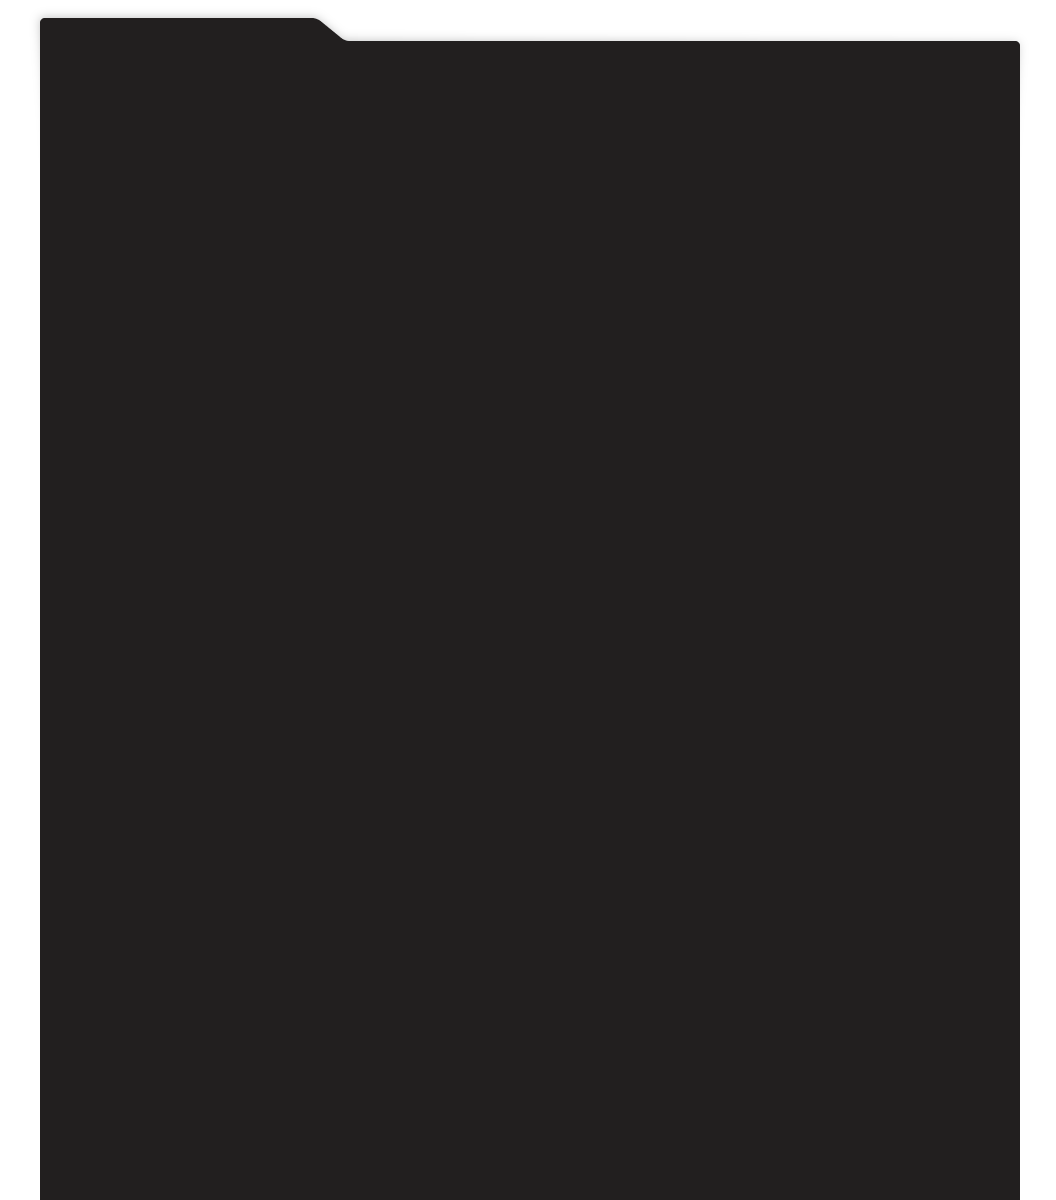
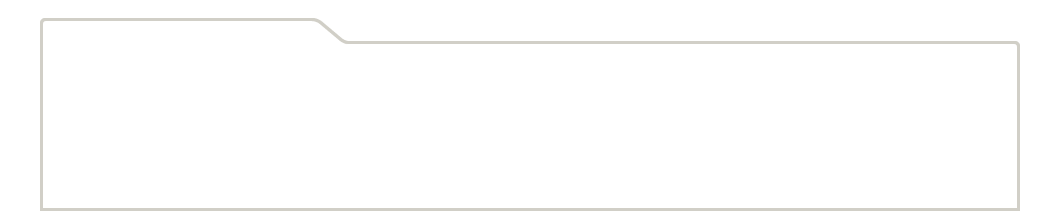
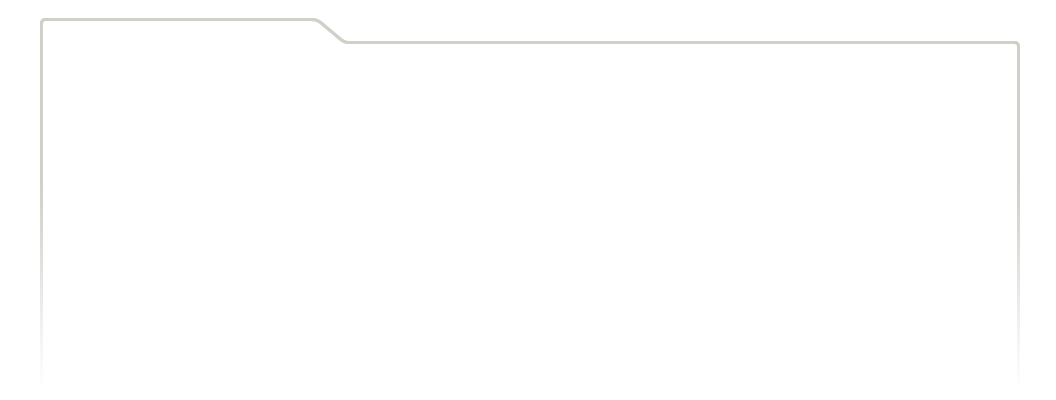
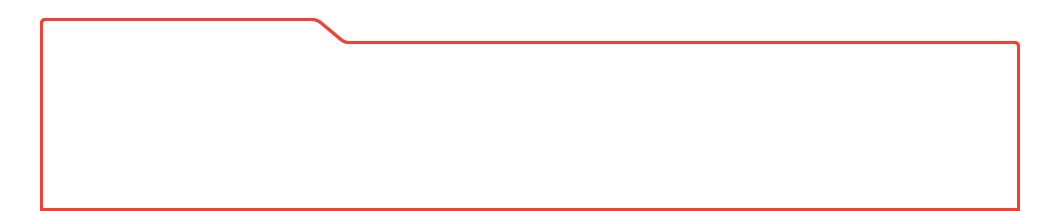
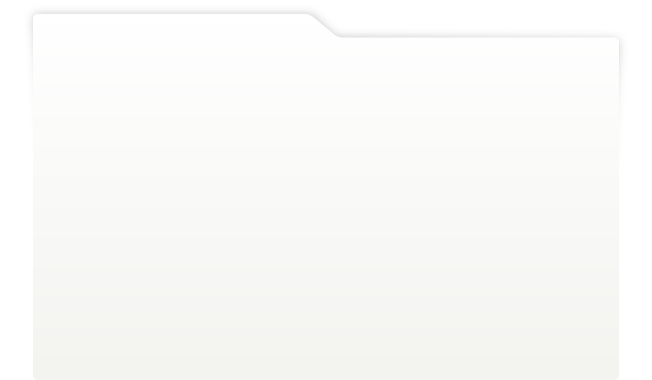
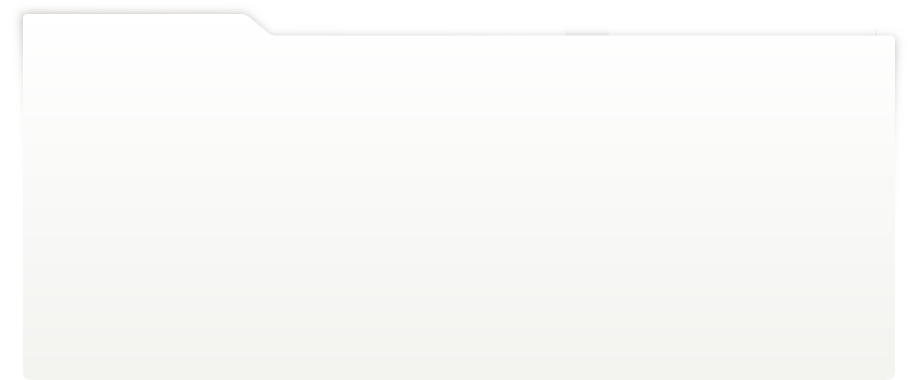
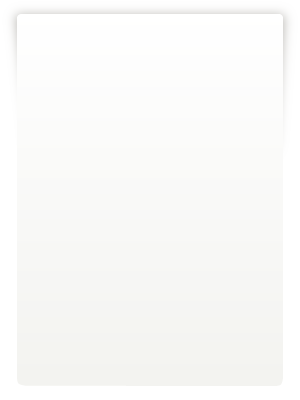
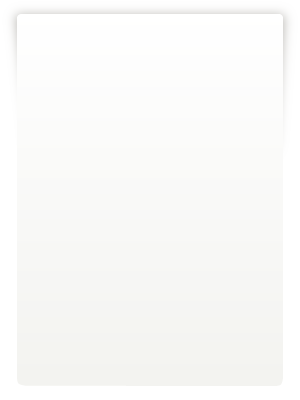
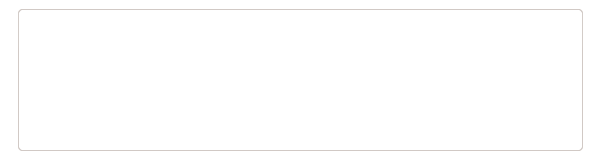
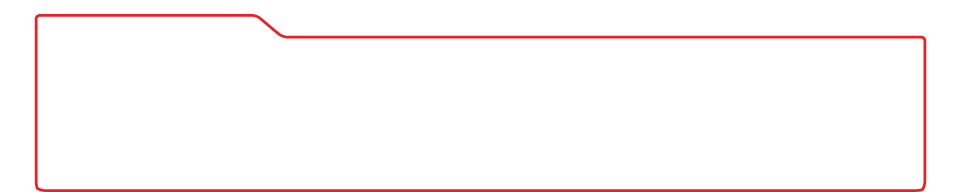
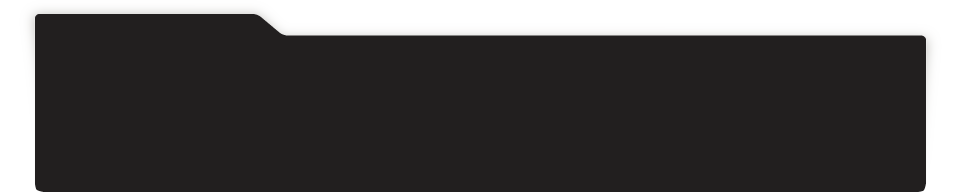
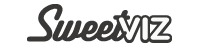
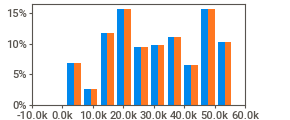
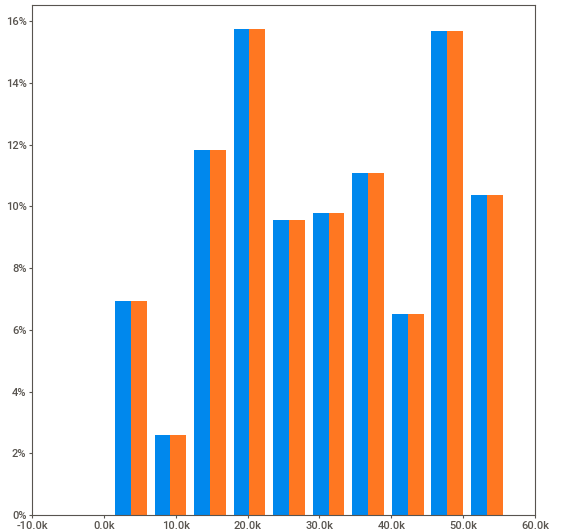
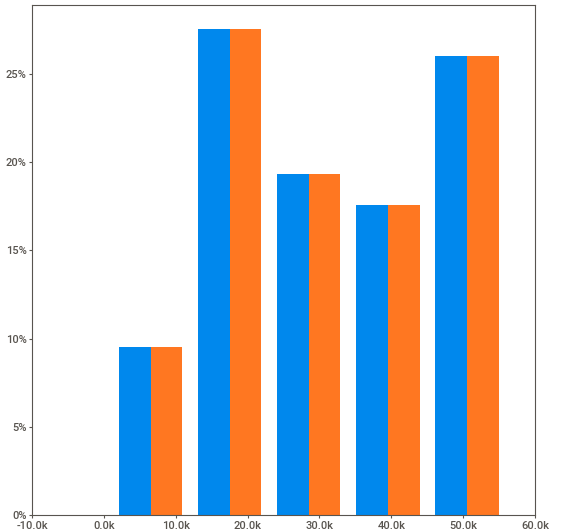
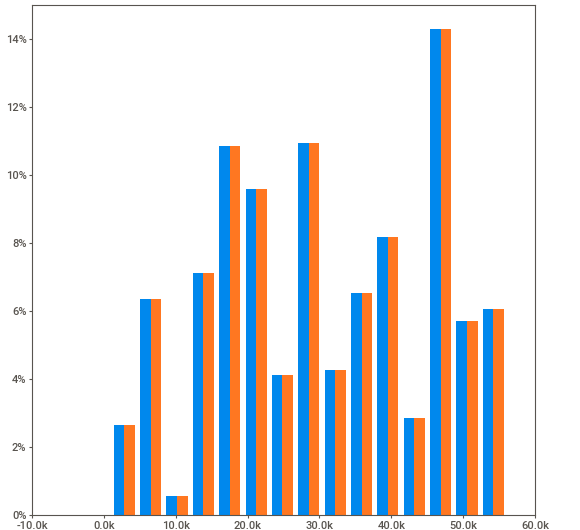
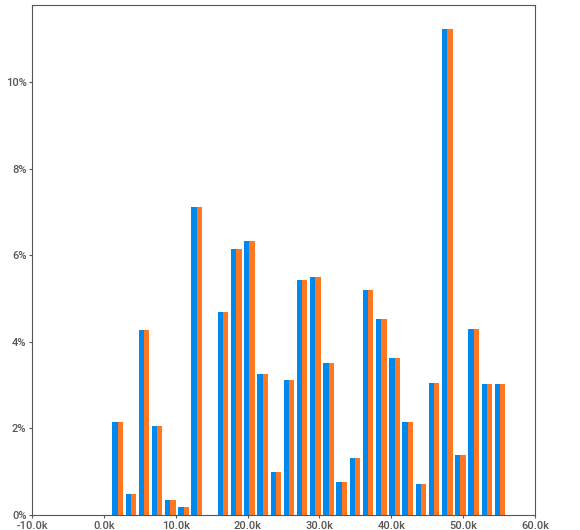
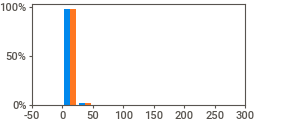
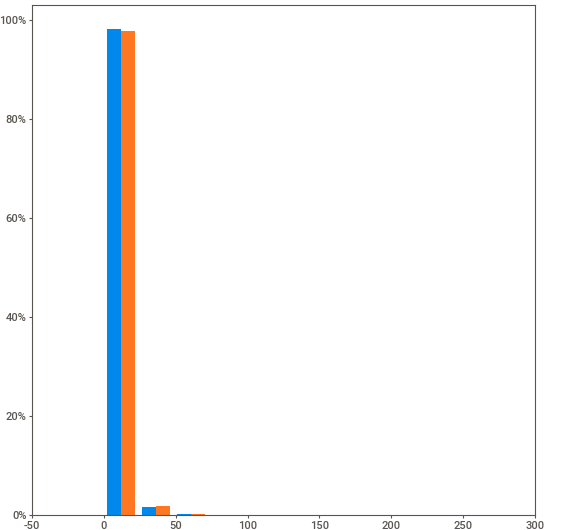
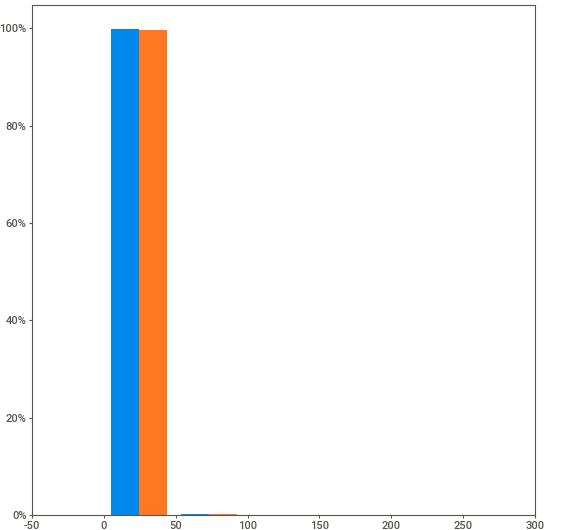
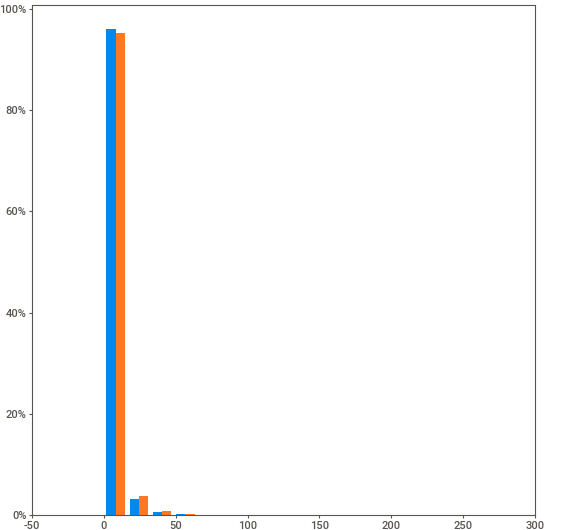
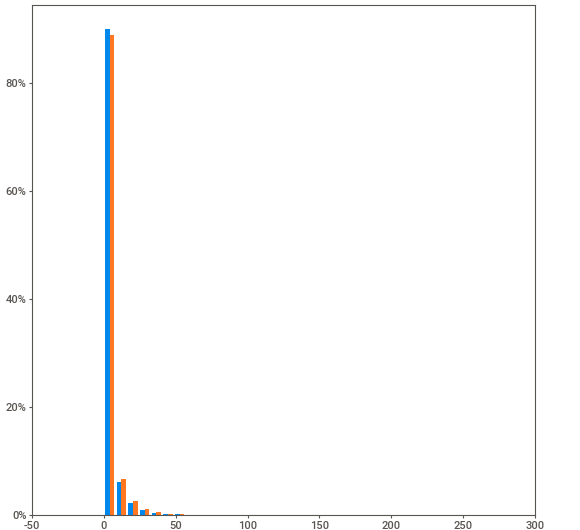
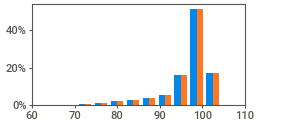
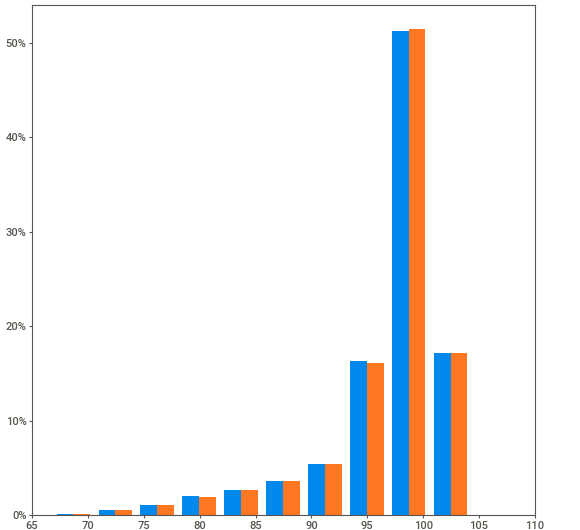
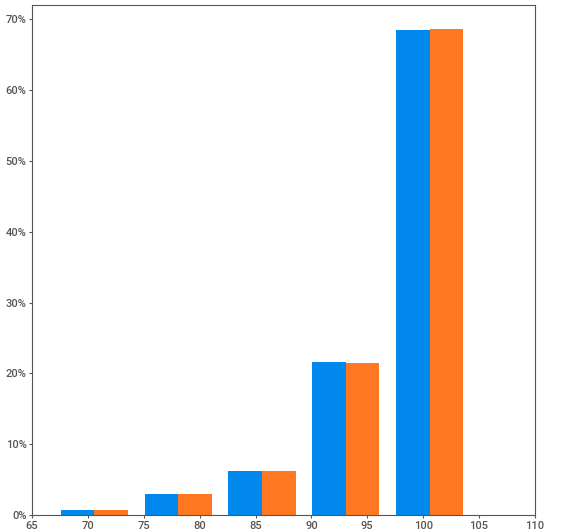
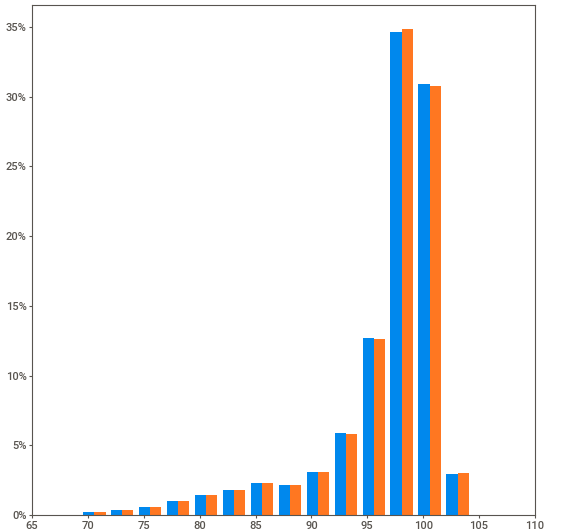
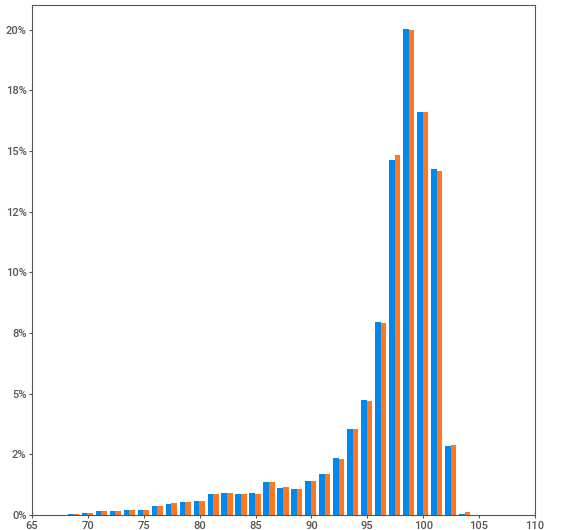
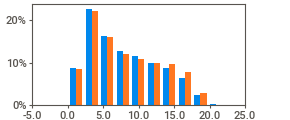
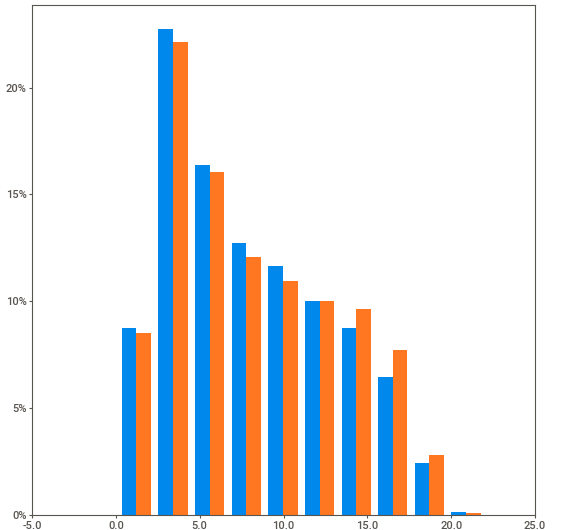
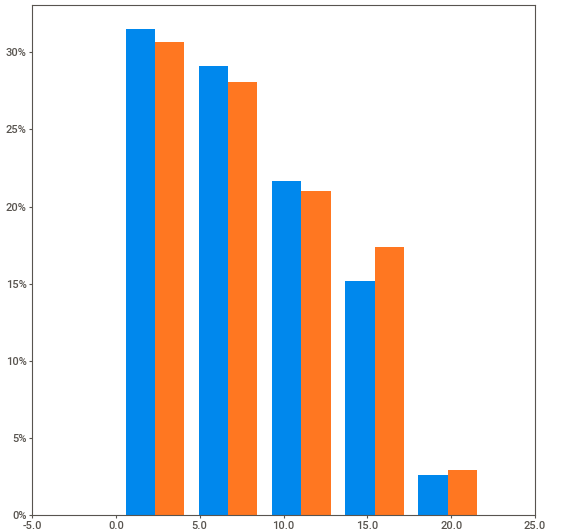
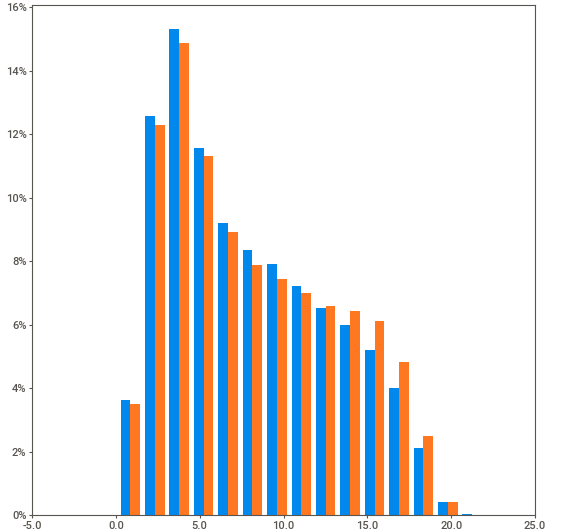
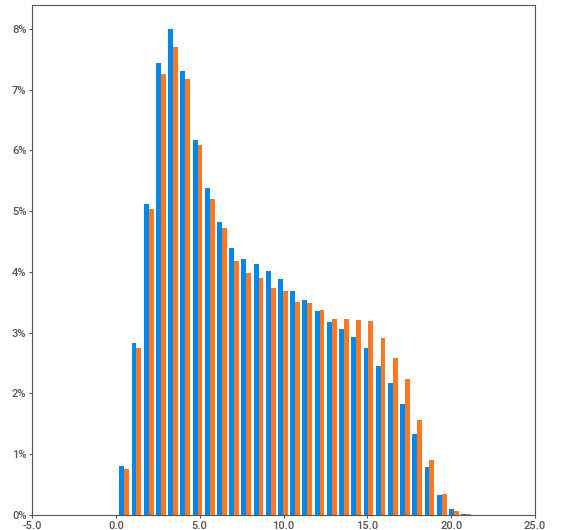
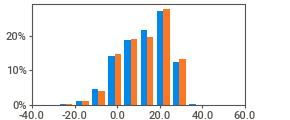
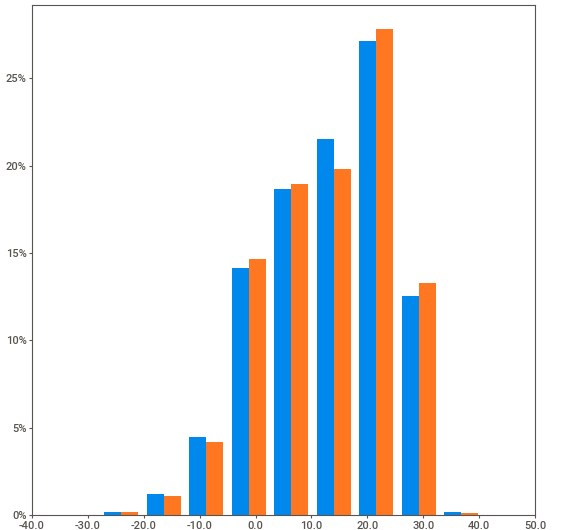
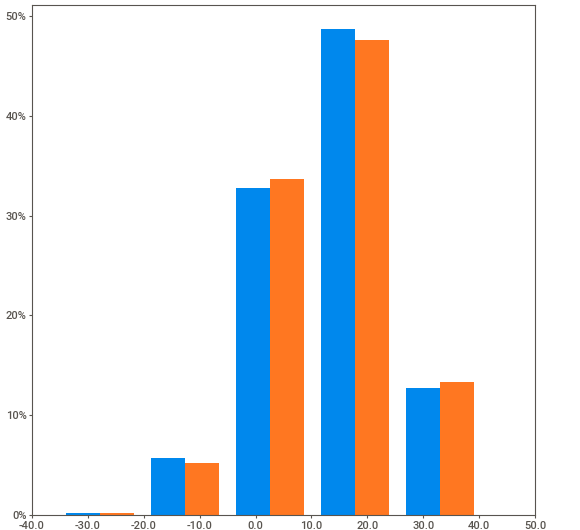
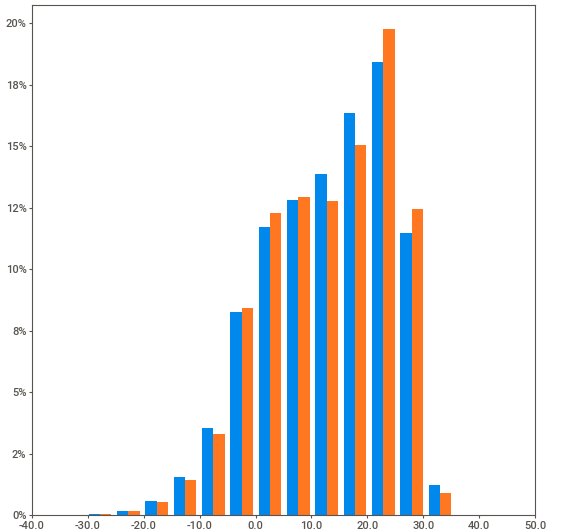
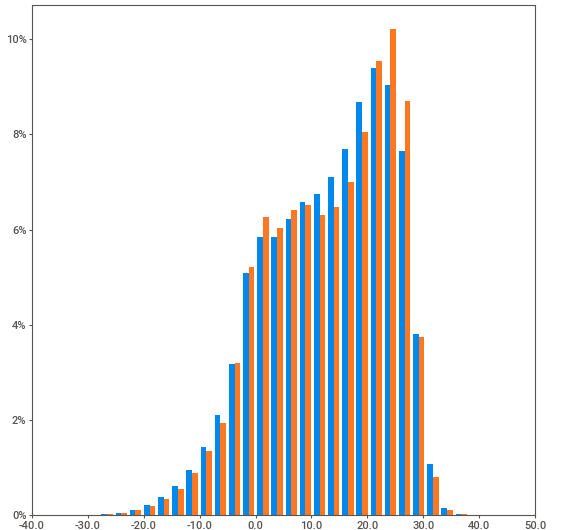
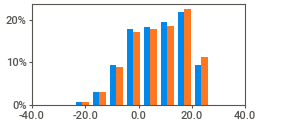
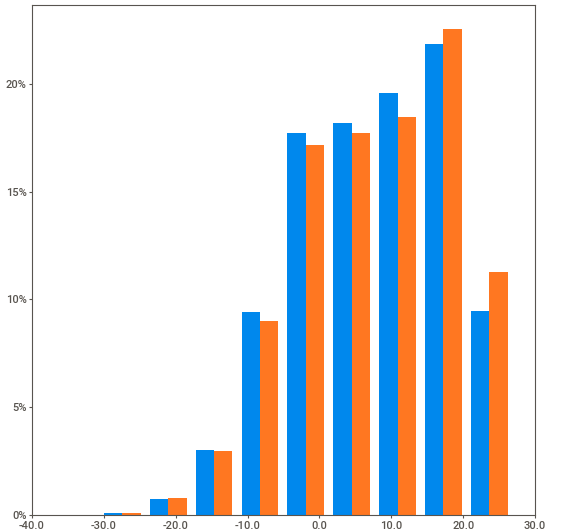
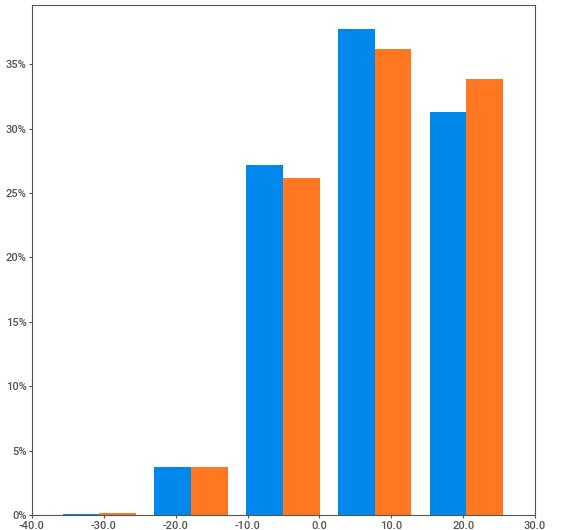
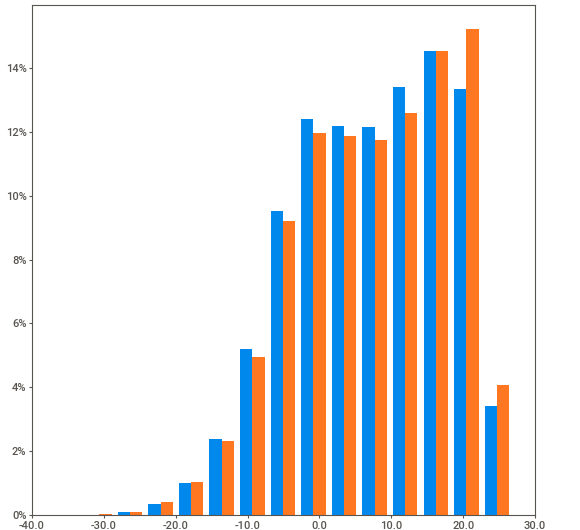
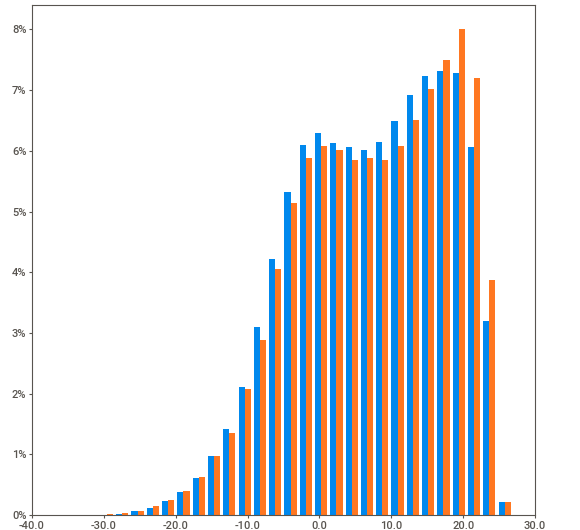
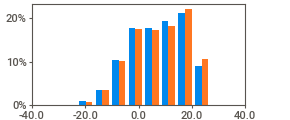
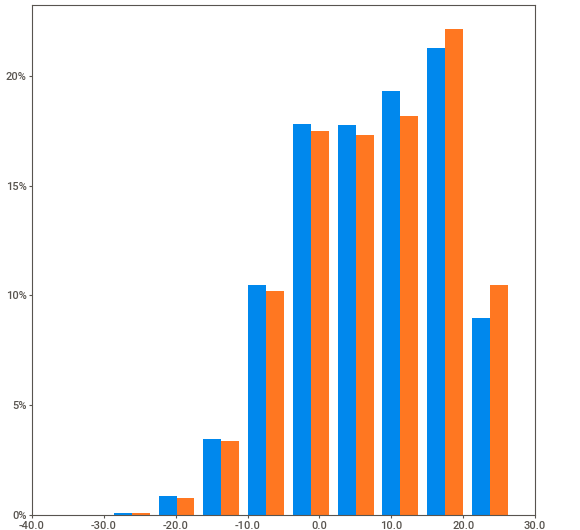
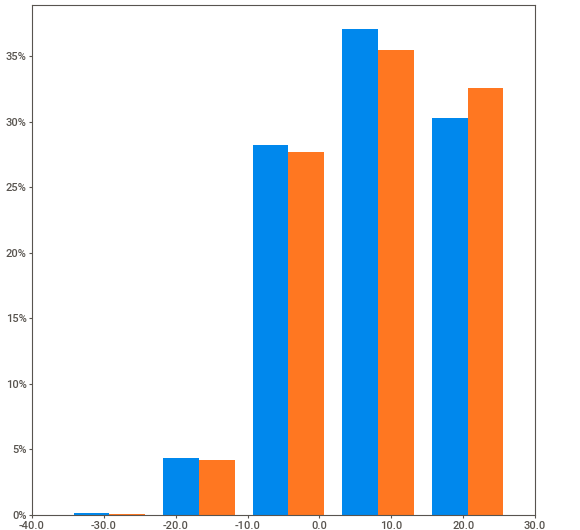
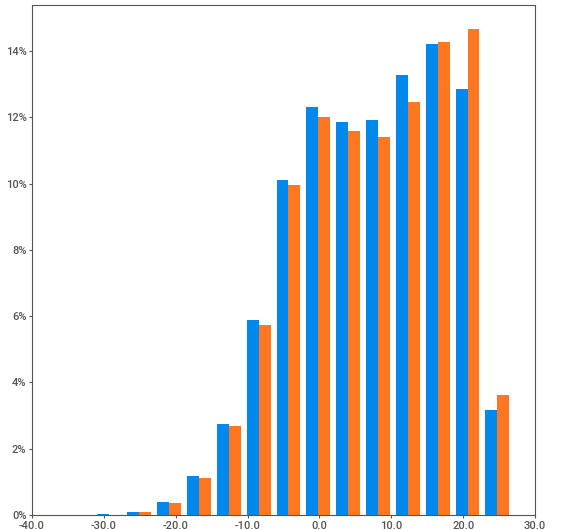
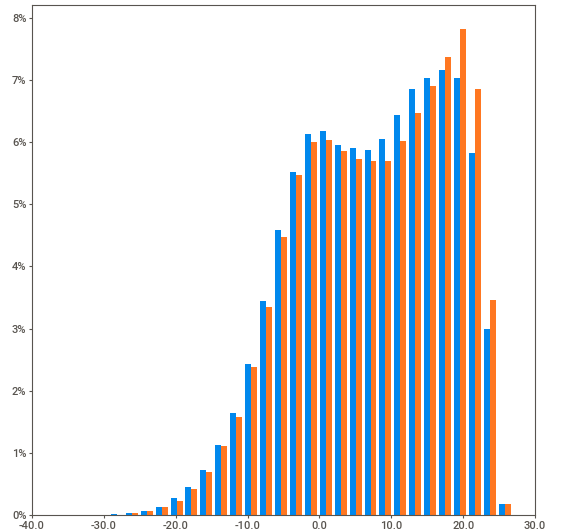
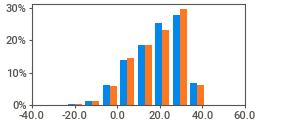
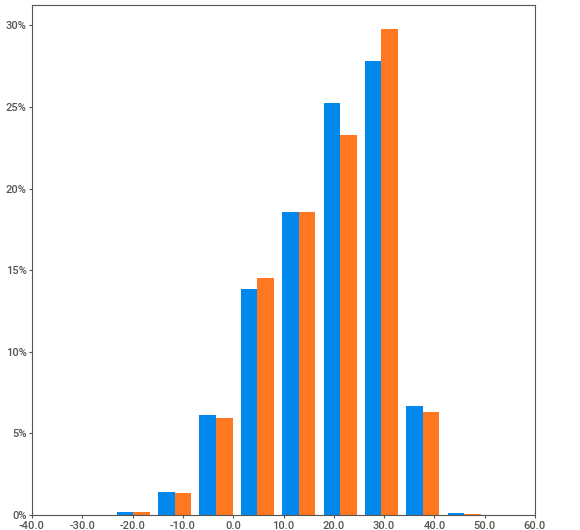
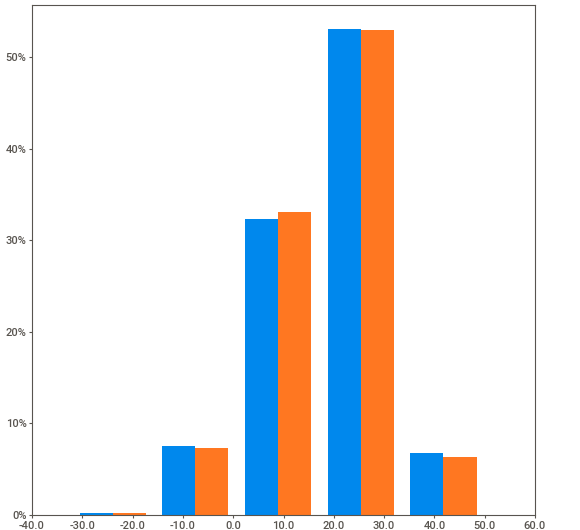
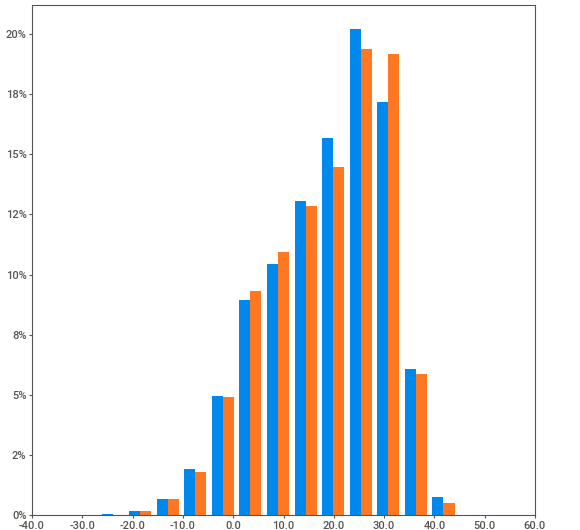
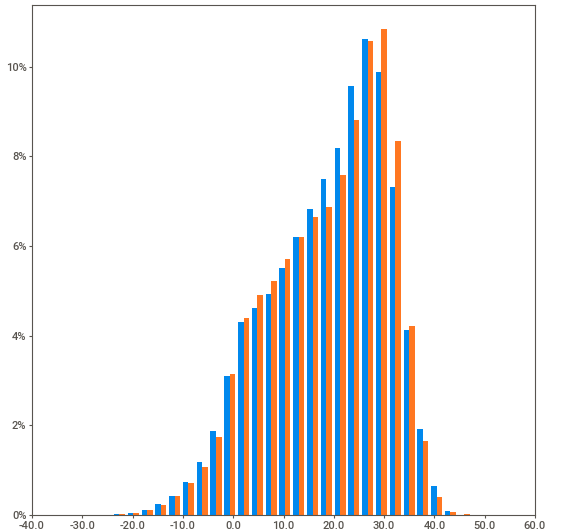
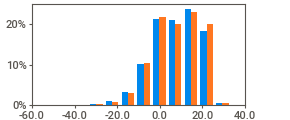
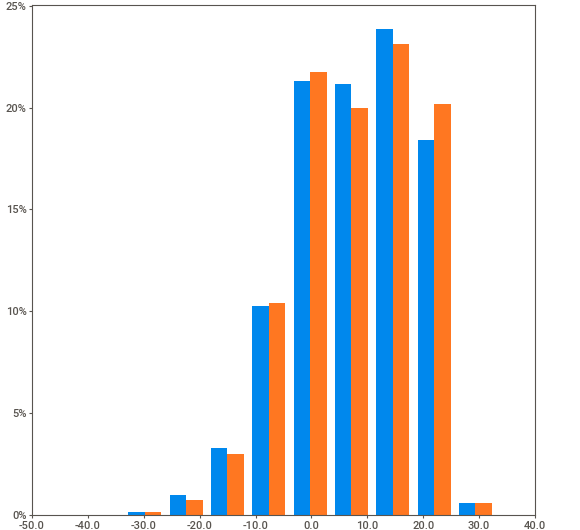
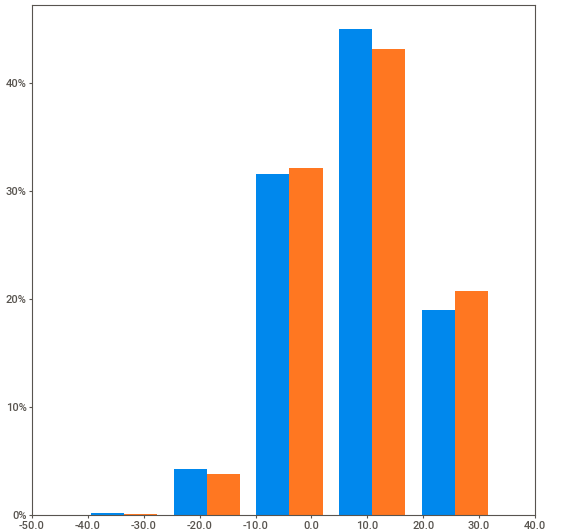
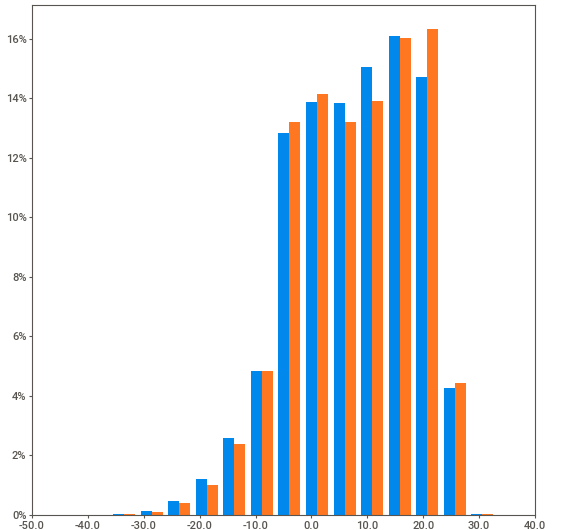
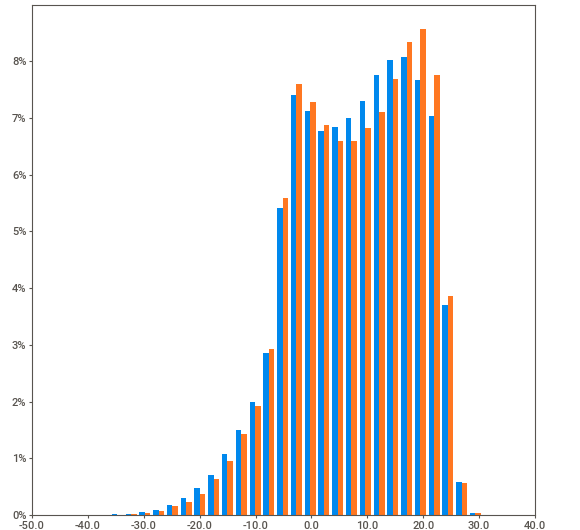
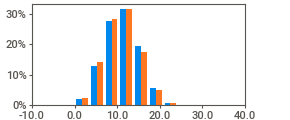
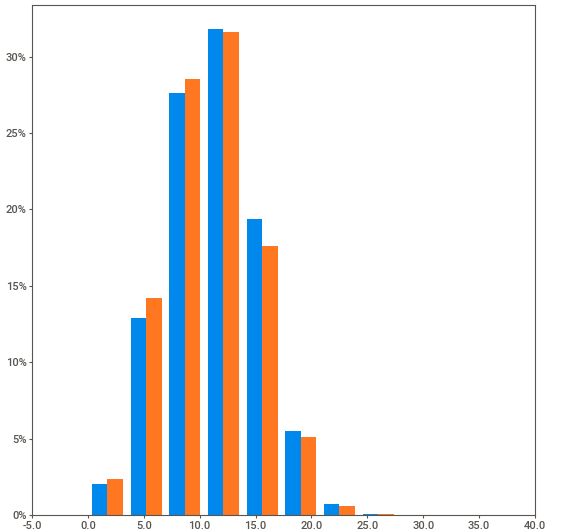
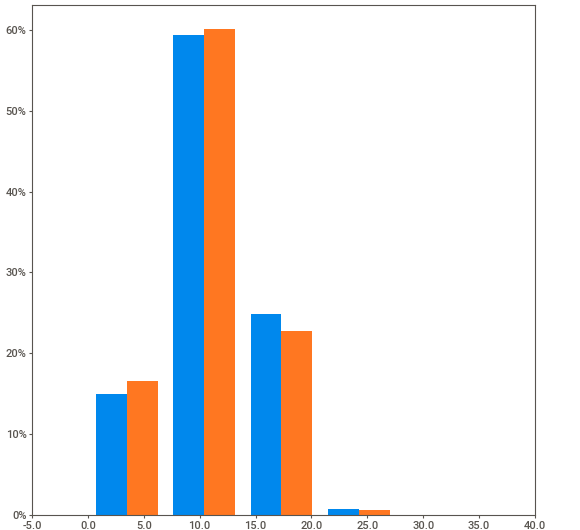
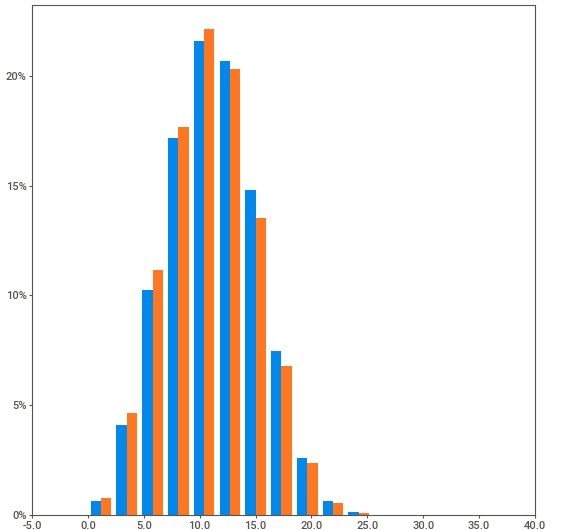
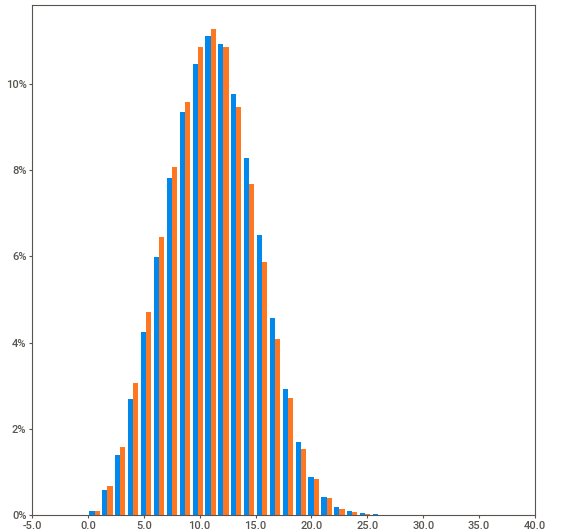
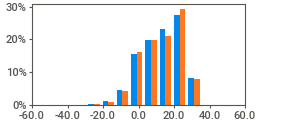
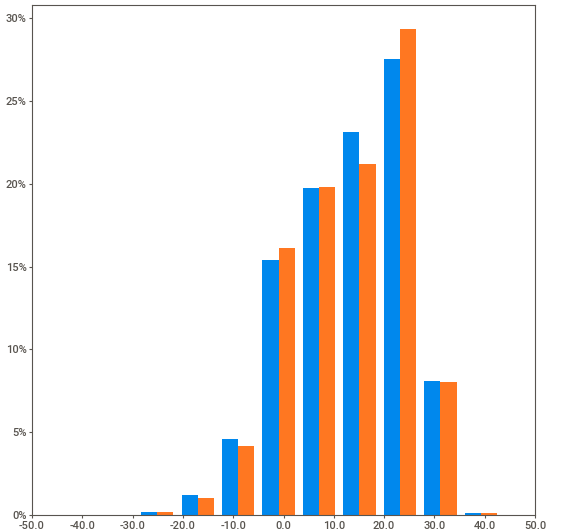
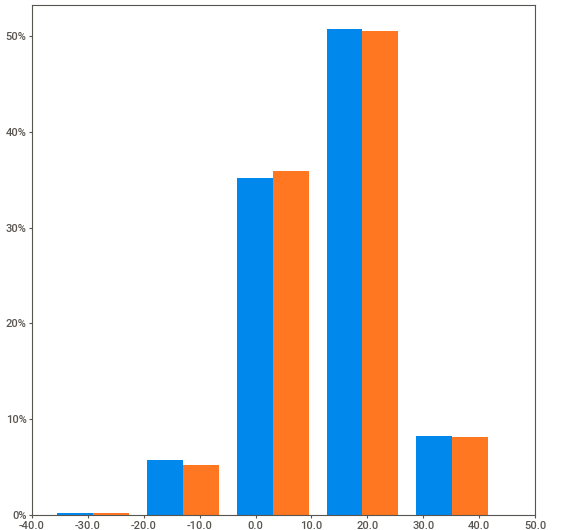
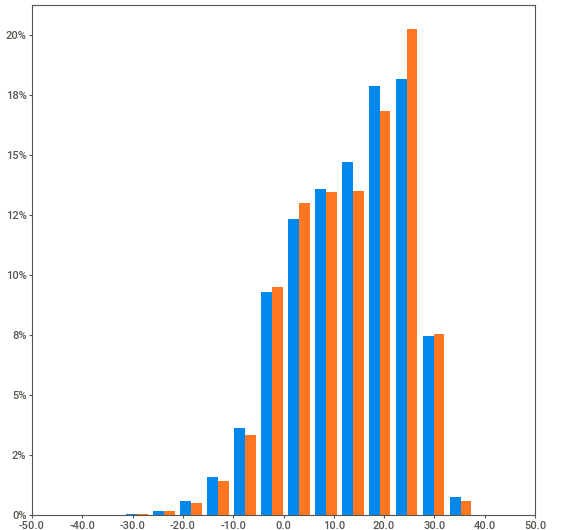
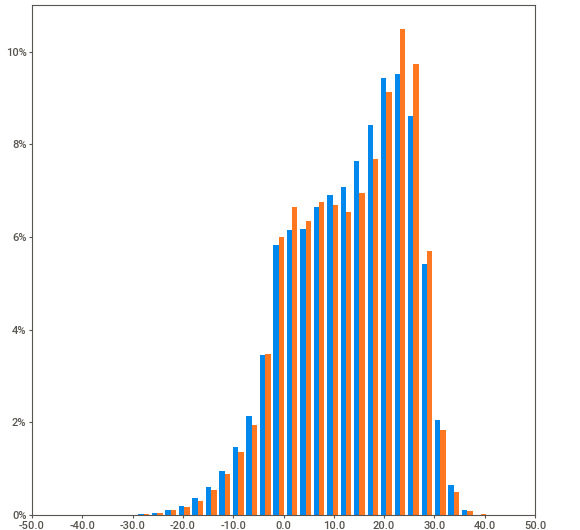
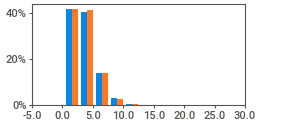
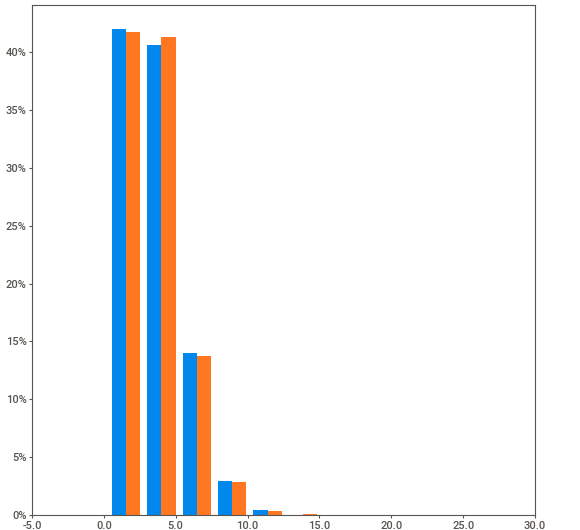
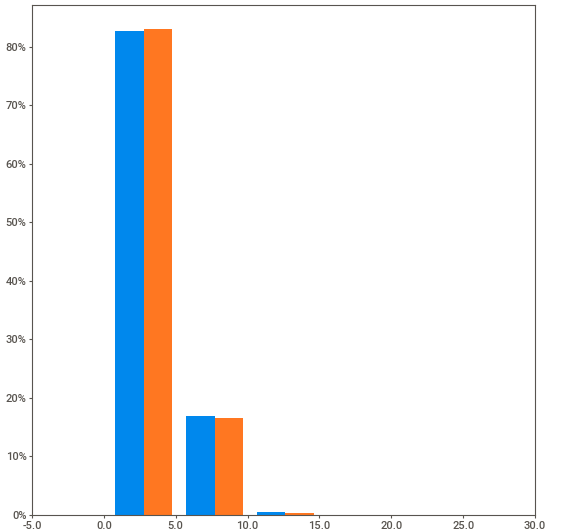
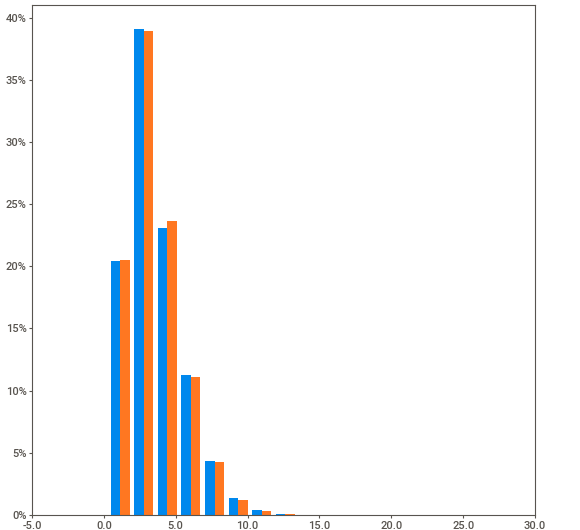
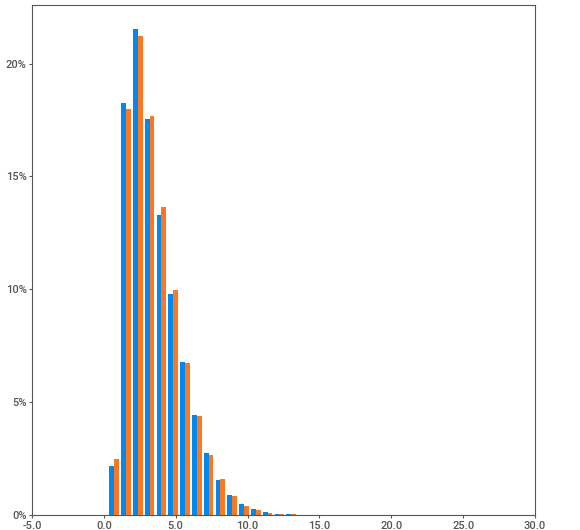
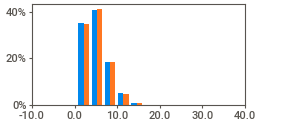
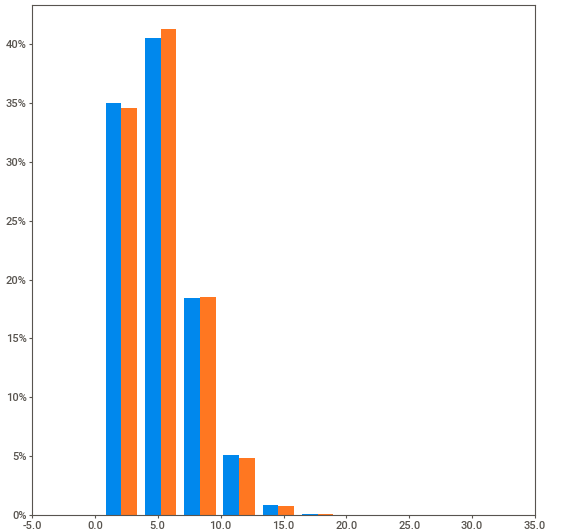
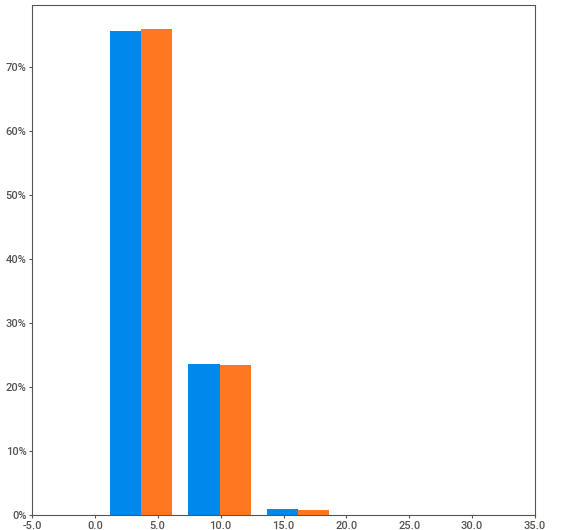
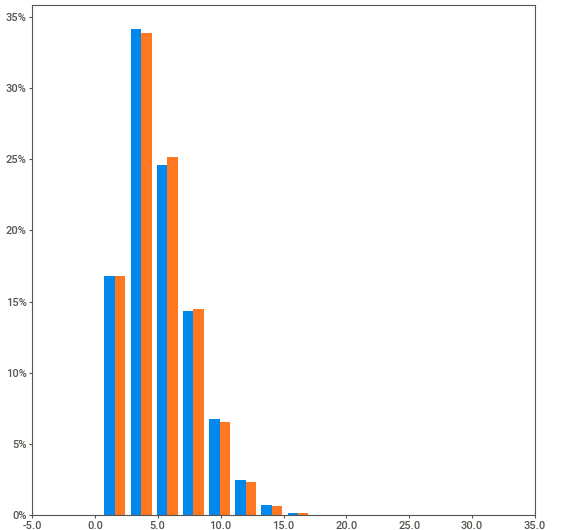
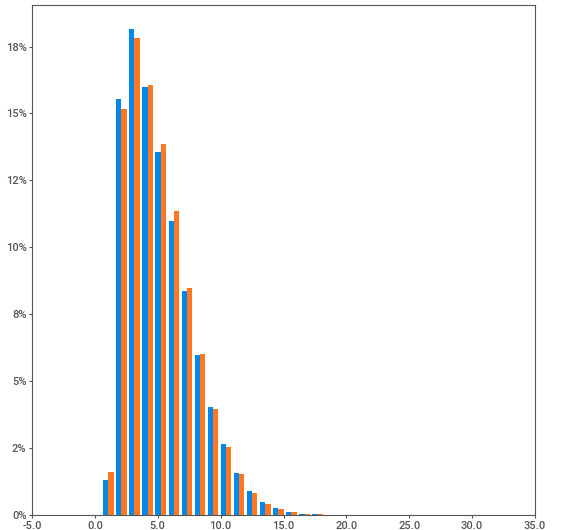
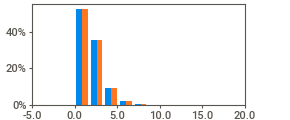
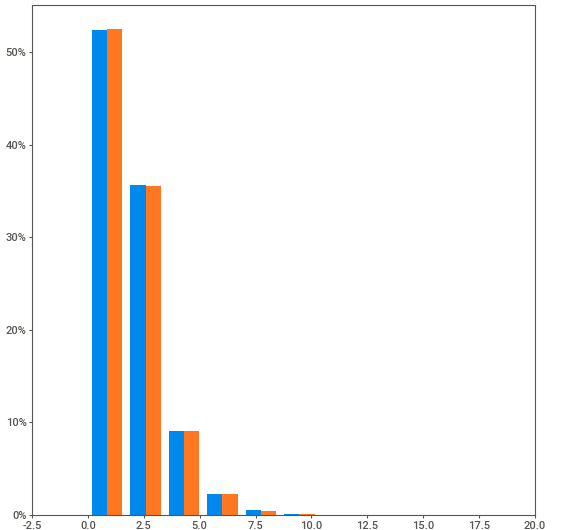
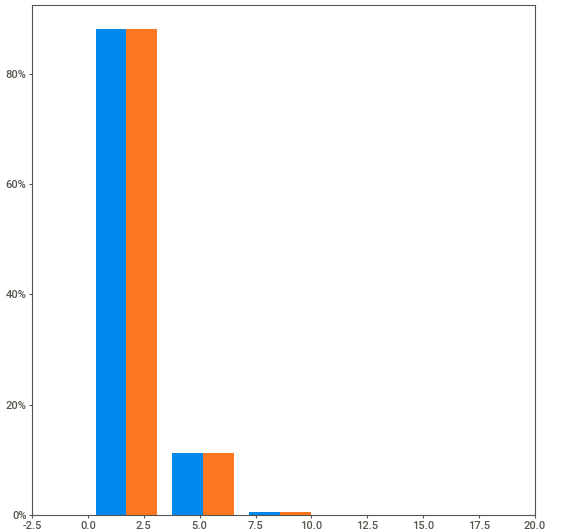
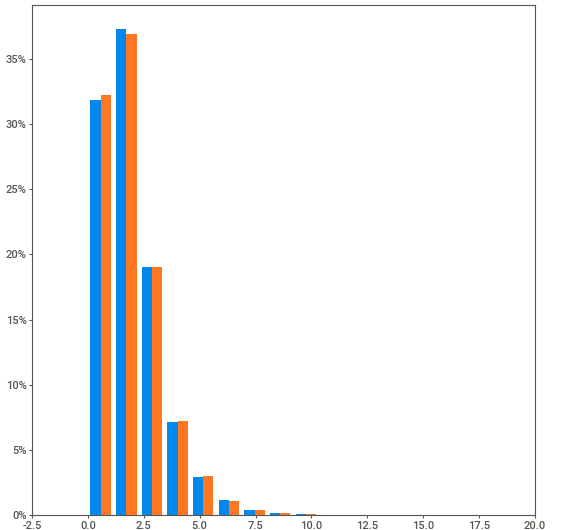
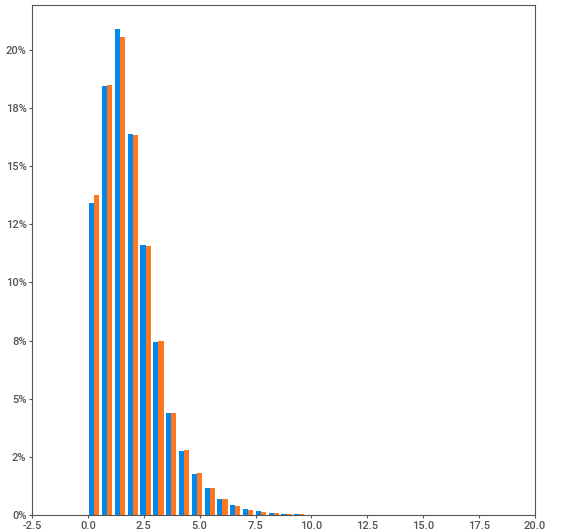
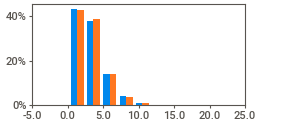
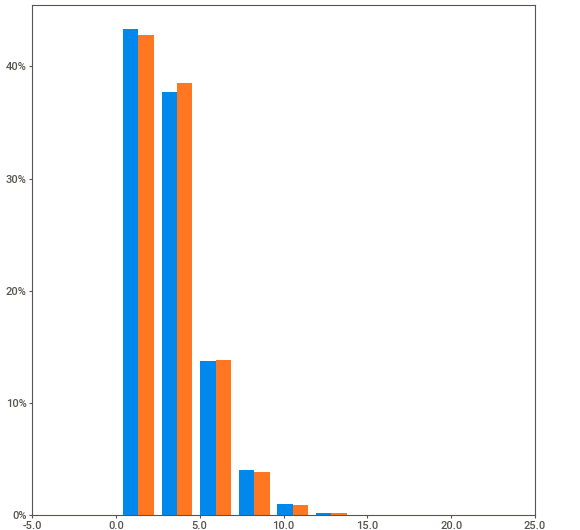
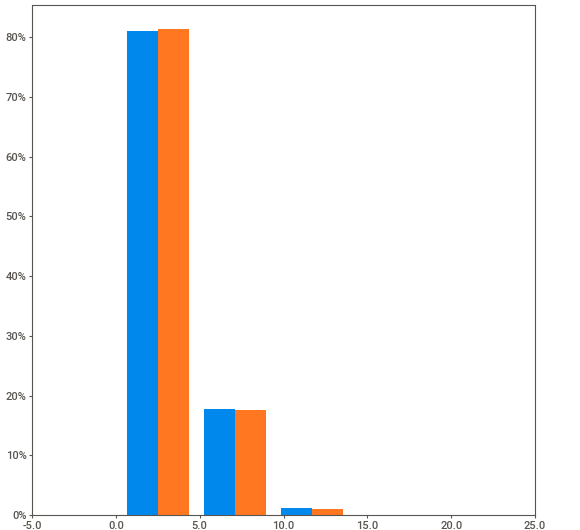
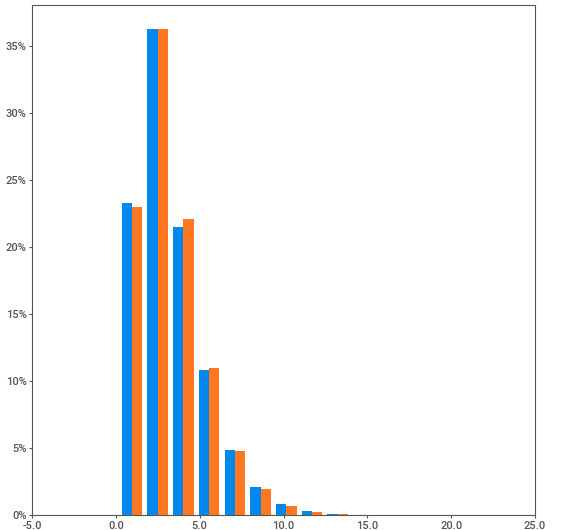
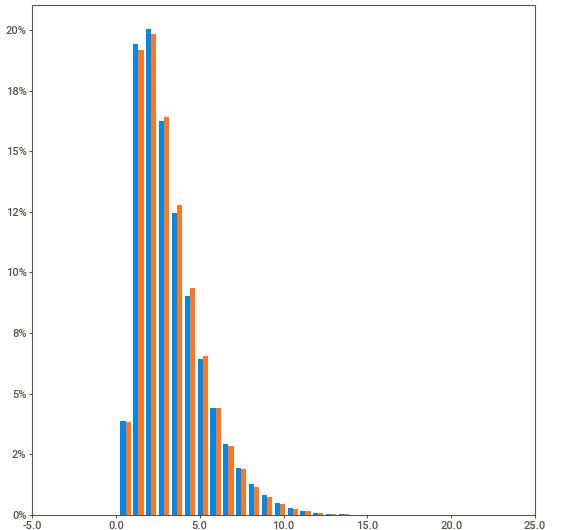
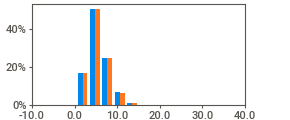
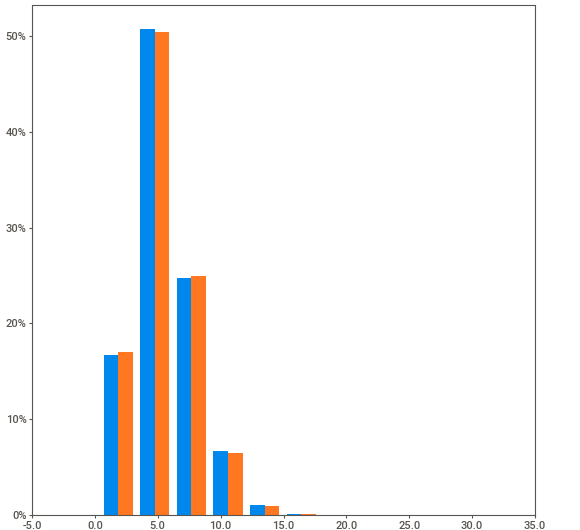
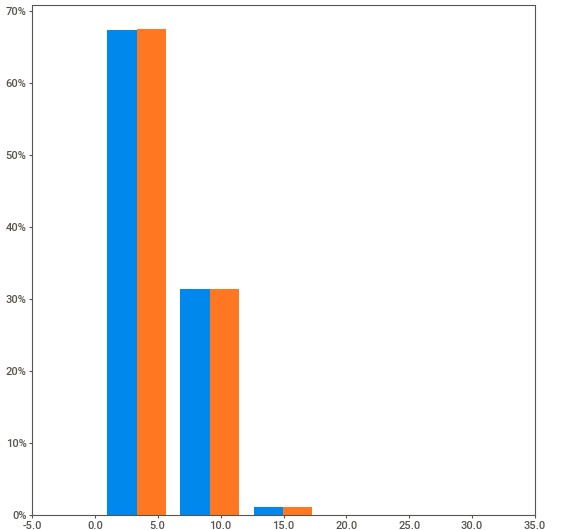
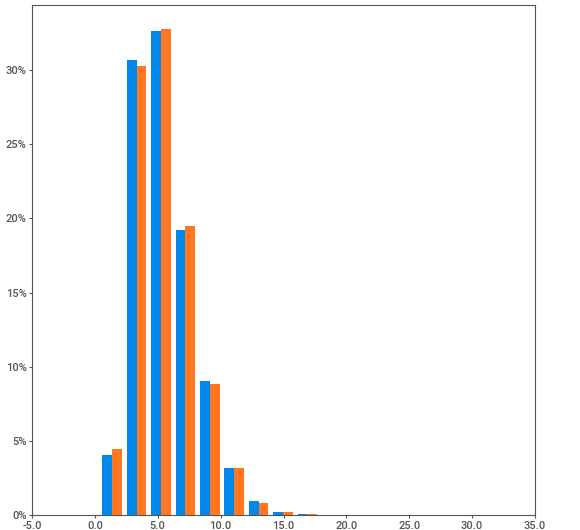
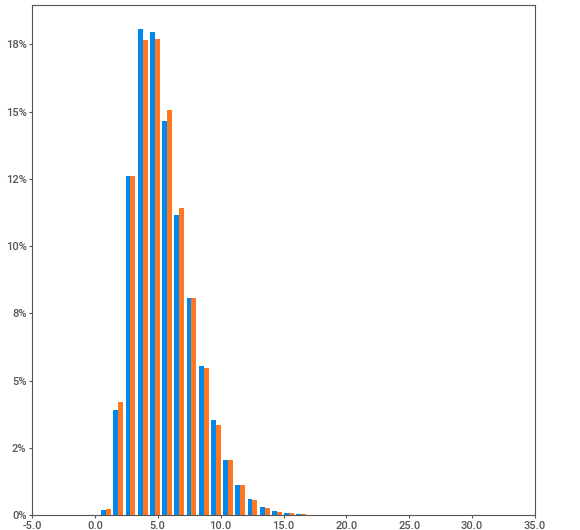
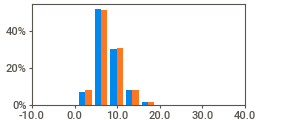
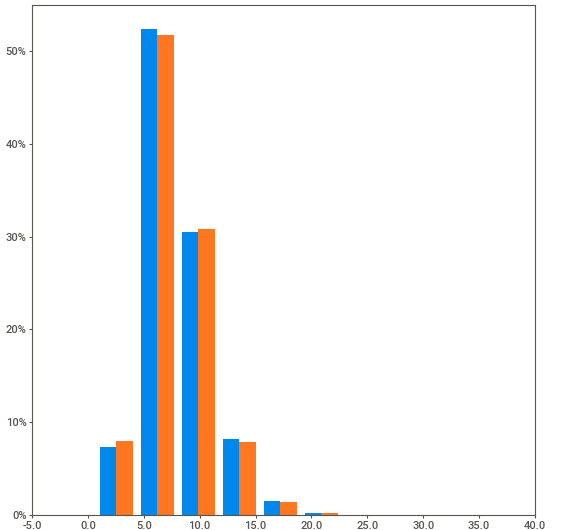
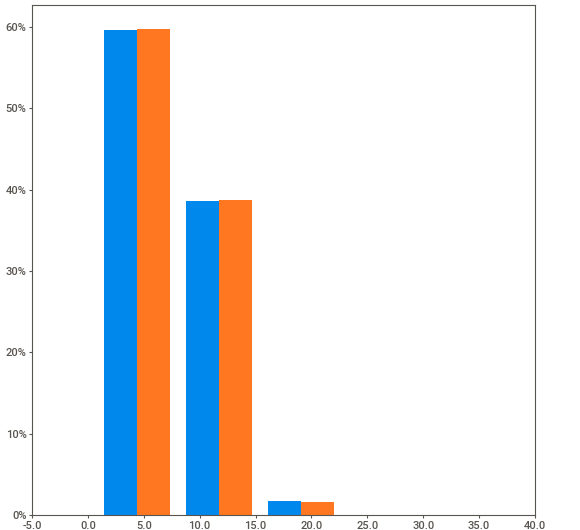
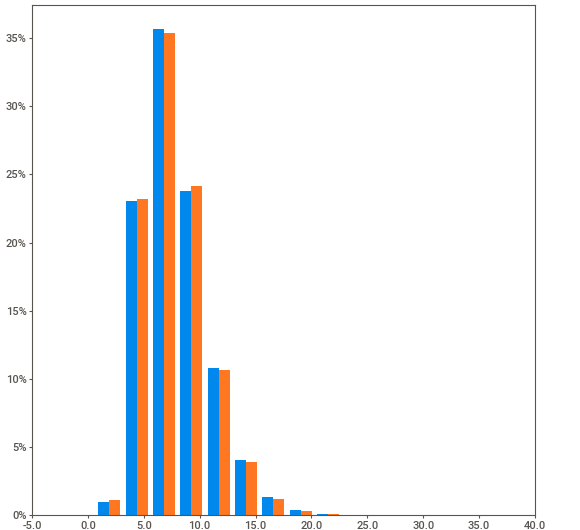
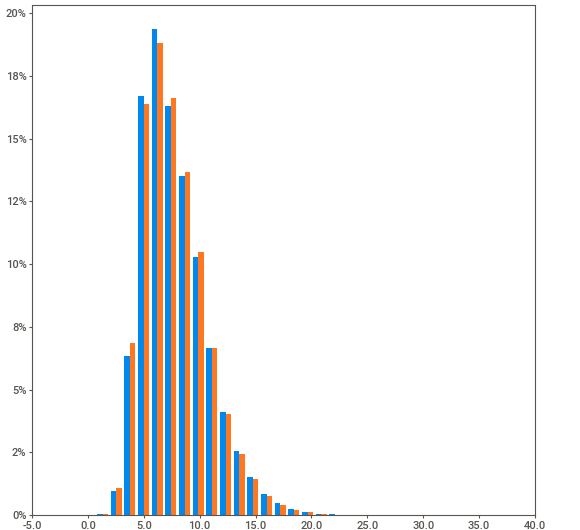
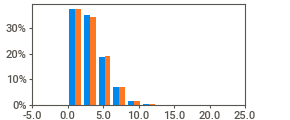
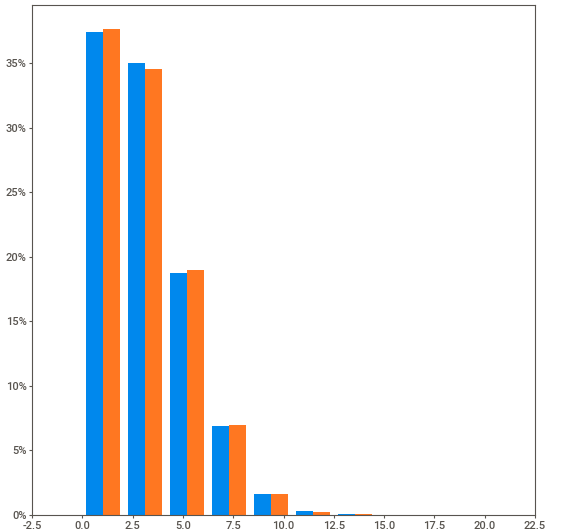
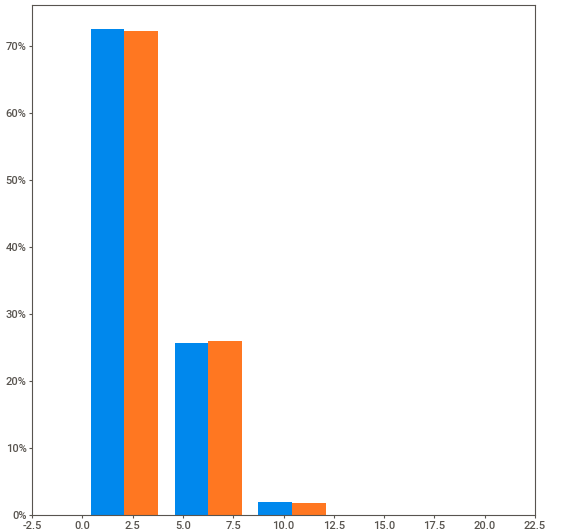
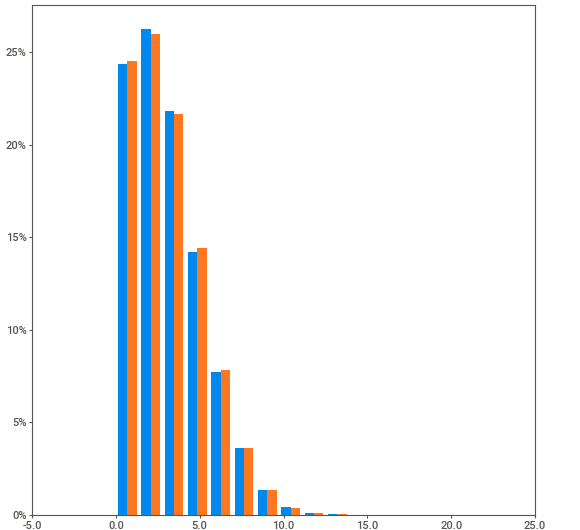
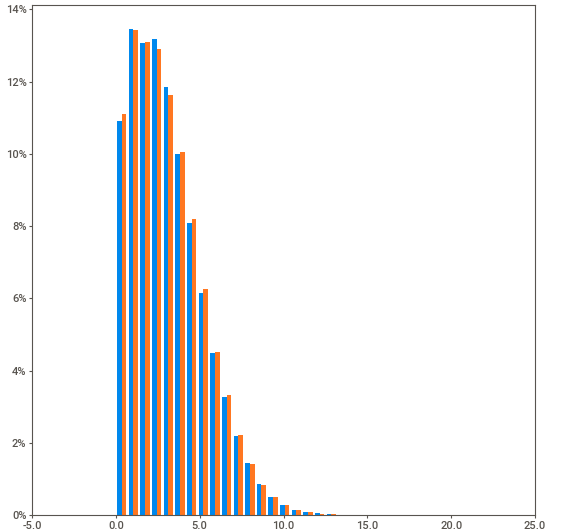
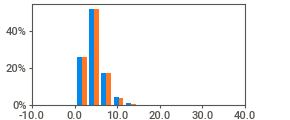
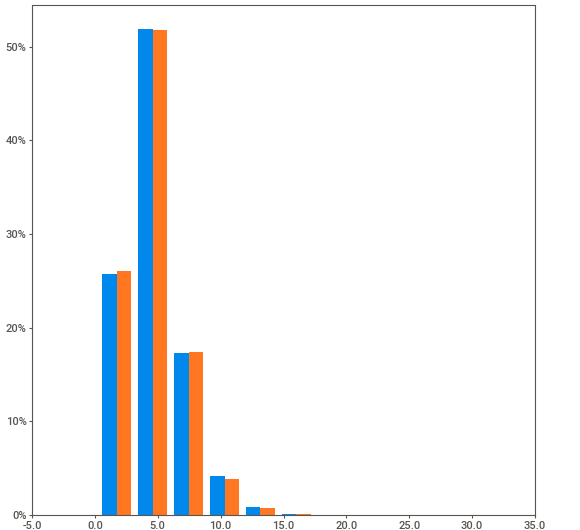
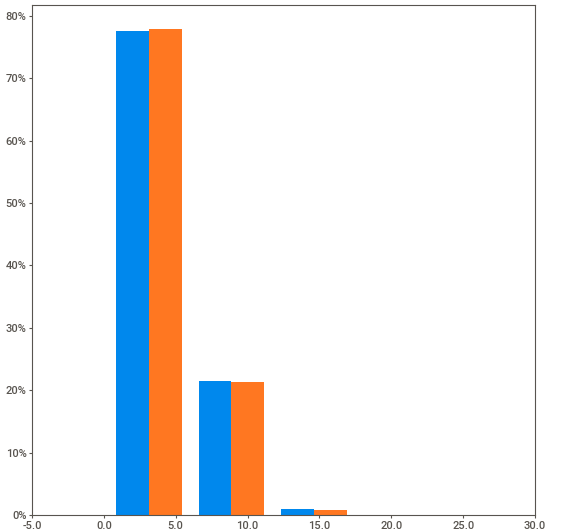
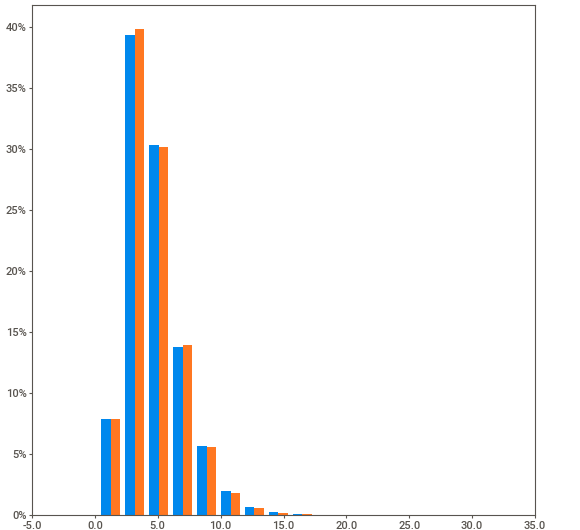
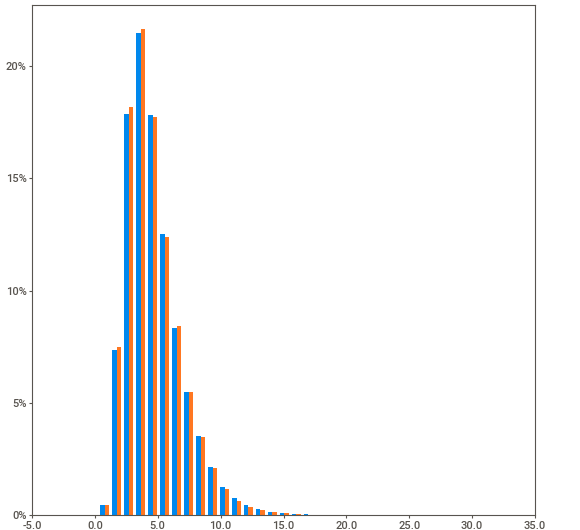
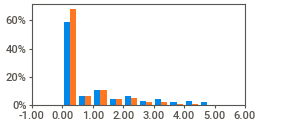
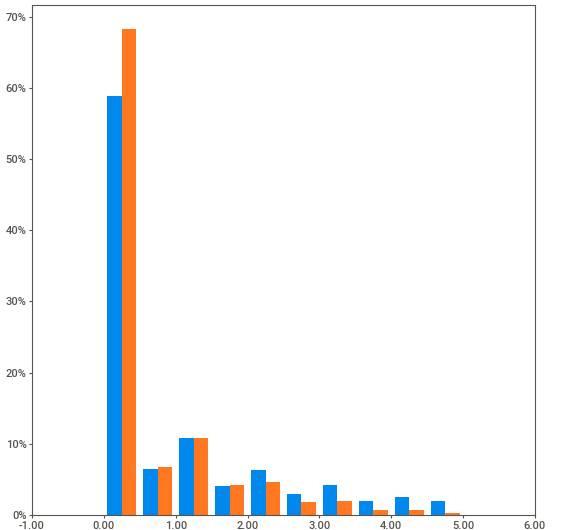
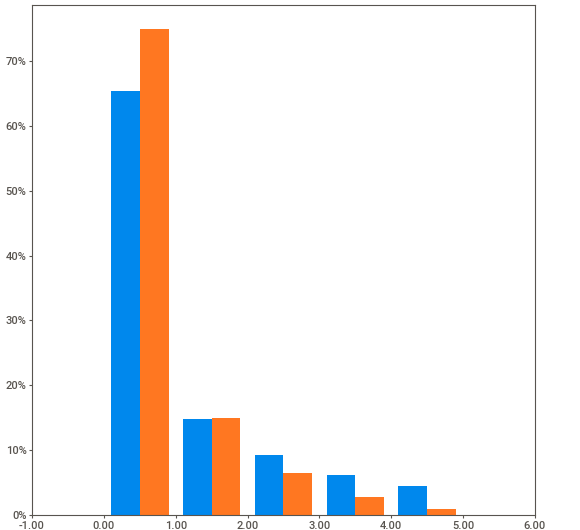
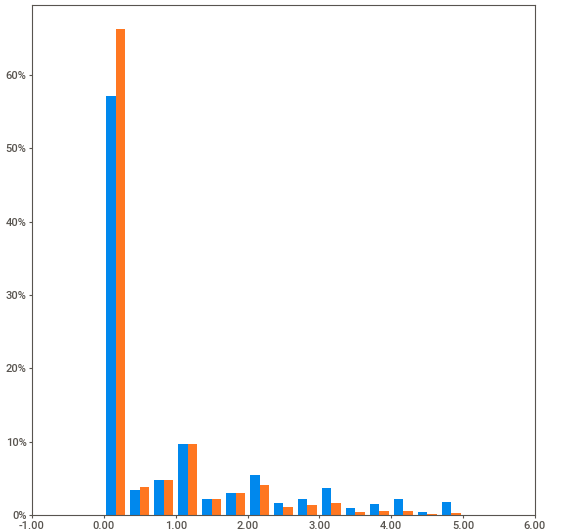
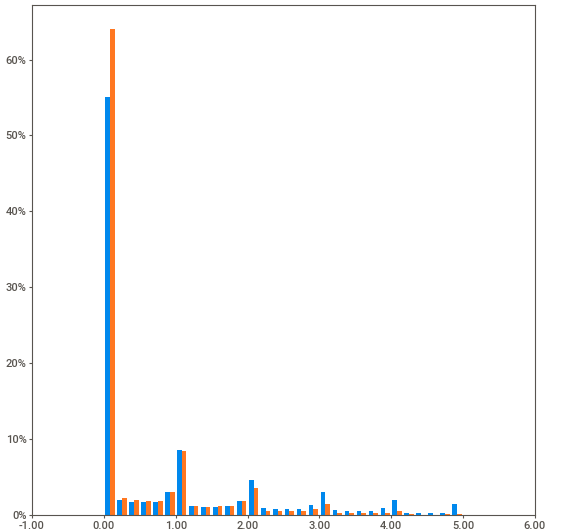
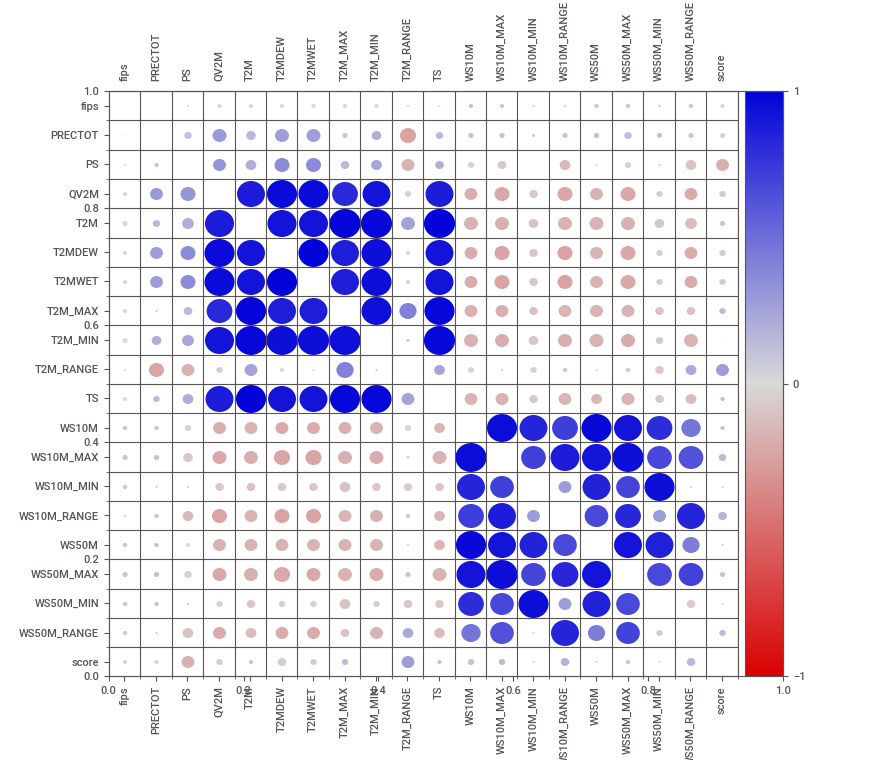
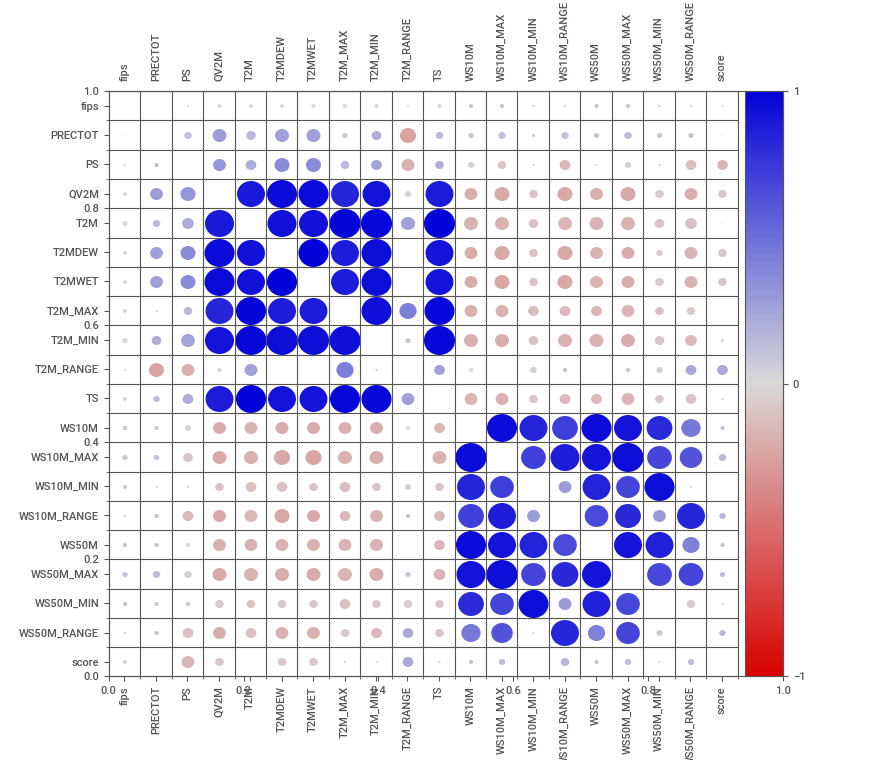

In [7]:
# comparo train_copy con val usando sweetviz
report = sv.compare([df_train_copy, "Train"], [df_val, "Validation"])
# guardo el reporte
report.show_notebook()

# Asignando valores a score

In [7]:
df_train.head()

fips        date  PRECTOT      PS  QV2M   T2M  T2MDEW  T2MWET  \
19300679  56043  2016-12-31     0.44   82.19  1.75 -7.56  -11.98  -11.82   
10799189  33017  2016-12-31     1.85   99.43  2.52 -5.04   -6.05   -6.02   
16816679  48437  2016-12-31     0.07   89.02  3.01  3.89   -5.18   -5.03   
825929     5101  2016-12-31     0.16   96.97  4.96  5.84    3.05    3.05   
2819339   13193  2016-12-31     4.32  100.50  4.07  6.29    0.60    0.64   

          T2M_MAX  T2M_MIN  ...     TS  WS10M  WS10M_MAX  WS10M_MIN  \
19300679    -0.95   -11.61  ... -10.17   2.31       3.47       0.41   
10799189    -0.04   -12.92  ...  -5.24   2.74       3.40       2.17   
16816679     8.20     1.27  ...   4.14   5.66       9.06       2.04   
825929       9.75     3.27  ...   5.43   2.03       3.74       0.32   
2819339     11.27     0.59  ...   5.62   2.26       3.99       0.78   

          WS10M_RANGE  WS50M  WS50M_MAX  WS50M_MIN  WS50M_RANGE  score  
19300679         3.06   3.37       5.26       0.66         4.60    NaN  
10799189         1.22   5.48       6.86       3.91         2.95    NaN  
16816679         7.01   7.78      12.33       3.43         8.89    NaN  
825929           3.42   3.84       7.25       0.69         6.56    NaN  
2819339          3.21   3.83       7.12       1.05         6.07    NaN  

[5 rows x 21 columns]

In [8]:
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler


# Si df_train_copy es un subconjunto, hacer una copia explícita
df_train_copy = df_train_copy.copy()

# Convertir la columna de fechas a datetime
df_train_copy['date'] = pd.to_datetime(df_train_copy['date'])

In [9]:
# Paso 1: Mantener la columna 'semana' original basada en isocalendar()
df_train_copy['semana'] = df_train_copy['date'].dt.isocalendar().week

# Paso 2: Crear una nueva columna 'semana_desde_2000' que calcule las semanas desde 2000-01-01
fecha_referencia = pd.to_datetime('2014-01-01')

# Calcular la diferencia en días entre cada fecha y la fecha de referencia
df_train_copy['dias_desde_referencia'] = (df_train_copy['date'] - fecha_referencia).dt.days

# Calcular las semanas desde la fecha de referencia
df_train_copy['semana_desde_2014'] = (df_train_copy['dias_desde_referencia'] // 7) + 1  # +1 para que la primera semana sea la número 1

# Verifica los resultados
print(df_train_copy[['date', 'semana', 'semana_desde_2014']].head())


               date  semana  semana_desde_2014
19300679 2016-12-31      52                157
10799189 2016-12-31      52                157
16816679 2016-12-31      52                157
825929   2016-12-31      52                157
2819339  2016-12-31      52                157


In [10]:
# Paso 1: Crear una función para rellenar los valores faltantes por grupo
def imputar_grupo(grupo):
    # Verificar si hay valores no nulos en el grupo
    if grupo['score'].notnull().any():
        # Rellenar los valores nulos con el primer valor no nulo del grupo
        return grupo['score'].fillna(grupo['score'].dropna().iloc[0])
    else:
        # Si todos son nulos, devolvemos el grupo tal cual
        return grupo['score']

# Paso 2: Aplicar la función al dataframe usando groupby y apply
# Rellenar los valores nulos con el primer valor no nulo dentro de cada grupo usando transform()
df_train_copy['score'] = df_train_copy.groupby(['fips', 'semana_desde_2014'])['score'].transform(lambda x: x.fillna(x.dropna().iloc[0]) if x.notnull().any() else x)


# Verificar si los valores nulos han sido imputados correctamente
print(df_train_copy[['fips', 'semana_desde_2014', 'score']].isnull().sum())




fips                     0
semana_desde_2014        0
score                12432
dtype: int64


In [11]:
mask = df_train_copy.score.isnull()
df_train_nulos = df_train_copy.loc[mask, :]
df_train_nulos.shape

(12432, 24)

In [12]:
df_train_nulos.date.value_counts()

date
2016-12-31    3108
2016-12-30    3108
2016-12-29    3108
2016-12-28    3108
Name: count, dtype: int64

In [13]:
#Elimino las filas con valores nulos en la columna 'score'

df_train_copy = df_train_copy.dropna(subset=['score'])

# Verificar si los valores nulos han sido eliminados
print(df_train_copy[['fips', 'semana_desde_2014', 'score']].isnull().sum())


fips                 0
semana_desde_2014    0
score                0
dtype: int64


In [14]:
# Si df_train_copy es un subconjunto, haz una copia explícita
df_train_copy = df_train_copy.copy()


# Redondear los valores de la columna 'score' a 0 decimales (puedes cambiar el número de decimales si lo prefieres)
df_train_copy['score'] = df_train_copy['score'].round(0)

# Verificar los resultados
print(df_train_copy[['fips', 'semana_desde_2014', 'score']].head())


           fips  semana_desde_2014  score
10513525  31145                156    1.0
12718075  39077                156    1.0
6483235   21169                156    1.0
8265505   27101                156    0.0
6309355   21113                156    1.0


In [15]:
df_train_copy.score.value_counts()

score
0.0    2259803
1.0     597156
2.0     273581
3.0     141729
4.0      78302
5.0      43365
Name: count, dtype: int64

In [17]:
df_train_copy.dtypes

fips                              int64
date                     datetime64[ns]
PRECTOT                         float64
PS                              float64
QV2M                            float64
T2M                             float64
T2MDEW                          float64
T2MWET                          float64
T2M_MAX                         float64
T2M_MIN                         float64
T2M_RANGE                       float64
TS                              float64
WS10M                           float64
WS10M_MAX                       float64
WS10M_MIN                       float64
WS10M_RANGE                     float64
WS50M                           float64
WS50M_MAX                       float64
WS50M_MIN                       float64
WS50M_RANGE                     float64
score                           float64
semana                           UInt32
dias_desde_referencia             int64
semana_desde_2014                 int64
dtype: object

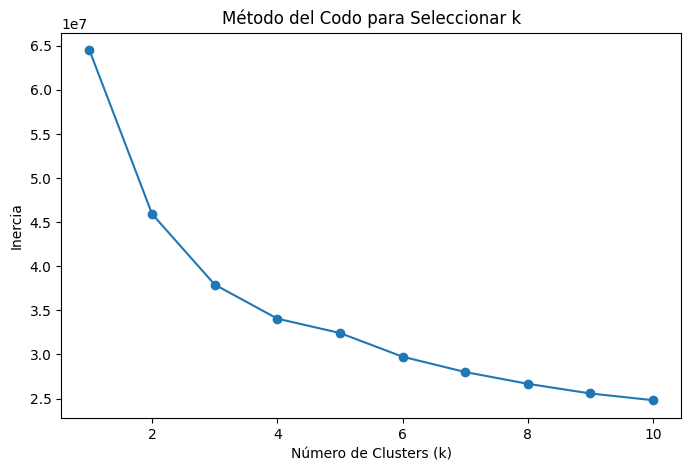

In [19]:
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Selección de columnas numéricas
columns_to_cluster = [
    'PRECTOT', 'PS', 'QV2M', 'T2M', 'T2MDEW', 'T2MWET', 'T2M_MAX', 
    'T2M_MIN', 'T2M_RANGE', 'TS', 'WS10M', 'WS10M_MAX', 'WS10M_MIN', 
    'WS10M_RANGE', 'WS50M', 'WS50M_MAX', 'WS50M_MIN', 'WS50M_RANGE', 
    'score'
]
X = df_train_copy[columns_to_cluster]

# Estandarización de los datos
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Determinar el número óptimo de clusters usando el método del codo
inertia = []
range_k = range(1, 11)
for k in range_k:
    kmeans = KMeans(n_clusters=k, random_state=0)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)

# Graficar el método del codo
plt.figure(figsize=(8, 5))
plt.plot(range_k, inertia, marker='o')
plt.xlabel('Número de Clusters (k)')
plt.ylabel('Inercia')
plt.title('Método del Codo para Seleccionar k')
plt.show()




KeyboardInterrupt: 

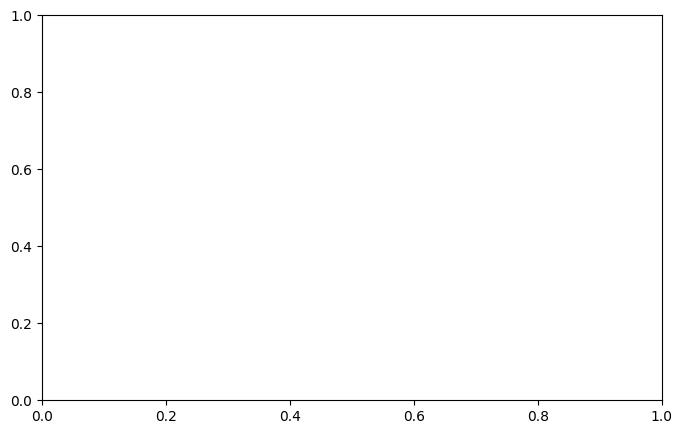

In [31]:
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import numpy as np

# Crear un gráfico de la silueta para un rango de valores k
range_k = range(2, 11)  # Empezando desde 2 porque la silueta no tiene sentido para k=1

for k in range_k:
    fig, ax = plt.subplots(1, 1)
    fig.set_size_inches(8, 5)

    # Inicializar KMeans y ajustar
    kmeans = KMeans(n_clusters=k, random_state=0)
    cluster_labels = kmeans.fit_predict(X_scaled)

    # Calcular el promedio de la silueta
    silhouette_avg = silhouette_score(X_scaled, cluster_labels)
    print(f'Para k = {k}, el promedio de la silueta es: {silhouette_avg:.4f}')

    # Calcular los coeficientes de silueta para cada punto
    sample_silhouette_values = silhouette_samples(X_scaled, cluster_labels)

    y_lower = 10
    for i in range(k):
        # Agrega los coeficientes de silueta de los clusters
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / k)
        ax.fill_betweenx(np.arange(y_lower, y_upper),
                         0, ith_cluster_silhouette_values,
                         facecolor=color, edgecolor=color, alpha=0.7)

        # Etiqueta en el gráfico
        ax.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        y_lower = y_upper + 10  # Añadir espacio entre clusters

    ax.set_title(f'Gráfico de la Silueta para k = {k}')
    ax.set_xlabel('Coeficiente de Silueta')
    ax.set_ylabel('Etiqueta del Cluster')

    # Línea vertical para el promedio de la silueta
    ax.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax.set_yticks([])  # No etiquetas en el eje y
    ax.set_xticks(np.arange(-0.1, 1.1, 0.2))

    plt.show()


In [20]:
# Seleccionar el número de clusters basado en la gráfica
k_optimo = 5  # Cambia este valor basado en la gráfica del codo
kmeans = KMeans(n_clusters=k_optimo, random_state=0)
df_train_copy['cluster'] = kmeans.fit_predict(X_scaled)

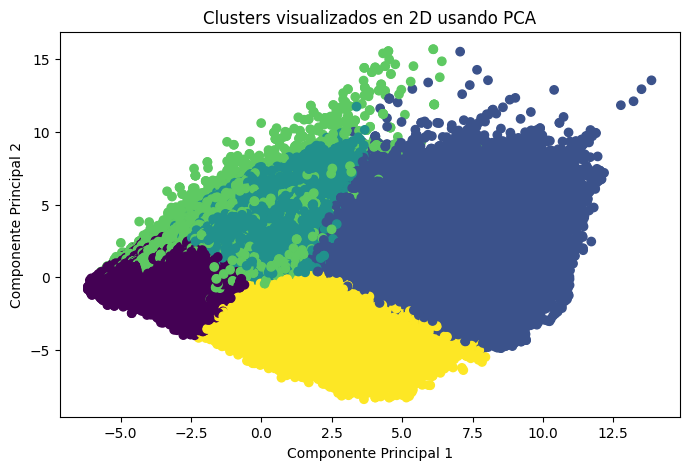

In [21]:
# Reducción de dimensionalidad usando PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Visualización de los clusters
plt.figure(figsize=(8, 5))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=df_train_copy['cluster'], cmap='viridis')
plt.xlabel('Componente Principal 1')
plt.ylabel('Componente Principal 2')
plt.title('Clusters visualizados en 2D usando PCA')
plt.show()

In [24]:
explained_variance_ratio = pca.explained_variance_ratio_
explained_variance_ratio

array([0.42382757, 0.24231984])

In [25]:
df_train_copy.cluster.value_counts()

cluster
0    1159888
4     993759
2     639796
1     470100
3     130393
Name: count, dtype: int64

# Mergeo con soil_data

In [26]:
df_soil = pd.read_csv('soil_data.csv')

In [27]:
df_soil.head()

fips        lat        lon  elevation  slope1  slope2  slope3  slope4  \
0  1001  32.536382 -86.644490         63  0.0419  0.2788  0.2984  0.2497   
1  1005  31.870670 -85.405456        146  0.0158  0.1868  0.5441  0.2424   
2  1003  30.659218 -87.746067         52  0.0746  0.4370  0.4415  0.0469   
3  1007  33.015893 -87.127148         93  0.0144  0.1617  0.3714  0.3493   
4  1009  33.977448 -86.567246        198  0.0050  0.0872  0.2799  0.3576   

   slope5  slope6  ...  CULTRF_LAND  CULTIR_LAND  CULT_LAND  SQ1  SQ2  SQ3  \
0  0.1142  0.0170  ...    56.293411     1.014811  57.308224    1    1    1   
1  0.0106  0.0003  ...    72.578804     1.828159  74.406960    3    2    1   
2  0.0000  0.0000  ...    59.843639     2.996914  62.840553    3    2    1   
3  0.0898  0.0134  ...     1.916593     0.008330   1.924924    3    2    1   
4  0.1477  0.1037  ...     1.891909     0.027488   1.919397    3    2    1   

   SQ4  SQ5  SQ6  SQ7  
0    1    1    1    2  
1    1    1    1    1  
2    2    1    1    1  
3    1    1    1    1  
4    1    1    1    1  

[5 rows x 32 columns]

In [28]:
print(df_train_copy.shape)
df_train_copy = pd.merge(df_train_copy, df_soil, on=['fips'], how='inner')
print(df_train_copy.shape)

(3393936, 25)
(3393936, 56)


In [23]:
pip install geopandas

   ---------------------------------------- 0.0/15.9 MB ? eta -:--:--
   --- ------------------------------------ 1.3/15.9 MB 9.5 MB/s eta 0:00:02
   ----- ---------------------------------- 2.1/15.9 MB 7.8 MB/s eta 0:00:02
   ------- -------------------------------- 2.9/15.9 MB 5.4 MB/s eta 0:00:03
   -------- ------------------------------- 3.4/15.9 MB 4.6 MB/s eta 0:00:03
   --------- ------------------------------ 3.9/15.9 MB 4.2 MB/s eta 0:00:03
   ----------- ---------------------------- 4.5/15.9 MB 3.8 MB/s eta 0:00:03
   ------------ --------------------------- 5.0/15.9 MB 3.5 MB/s eta 0:00:04
   ------------- -------------------------- 5.5/15.9 MB 3.4 MB/s eta 0:00:04
   --------------- ------------------------ 6.0/15.9 MB 3.3 MB/s eta 0:00:04
   ---------------- ----------------------- 6.6/15.9 MB 3.2 MB/s eta 0:00:03
   ----------------- ---------------------- 7.1/15.9 MB 3.1 MB/s eta 0:00:03
   ------------------- -------------------- 7.6/15.9 MB 3.0 MB/s eta 0:00:03
   ---

  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.


In [22]:
import geopandas as gpd

ModuleNotFoundError: No module named 'geopandas'

In [ ]:
df_train_2.head()